# Matrix Methods for Cost-Effectiveness Analysis and Health Technology

Assessment - A Tutorial

John Graves  
Ashley Leech  
Jinyi Zhu  
Grace Ratcliff  
Hanxuan Yu  
Shawn Garbett  
July 11, 2024

Abstract goes here.

## 0.1 Introduction

## 0.2 Model Overview

We build on an existing progressive disease model in which healthy individuals develop a disease with two health states (“Sick” and “Sicker”; Alarid-Escudero et al. ([2023](#ref-alarid2023introductory))). Individuals can also transition to an absorbing death state due to causes unrelated to the disease (i.e., “background” mortality), or due to disease-specific causes.

We consider outcomes under four strategies:

-   A **Standard of Care** strategy based on the baseline model parameters.
-   **Strategy A**, which improves the quality of life among individuals with the disease, but does not affect disease progression.
-   **Strategy B**, which reduces the rate of progression from Sick to Sicker by 40%.
-   **Composite Strategy AB**, which jointly implements strategies A and B.

A state transition diagram is shown in <a href="#fig-model1" class="quarto-xref">Figure 1</a>. In the figure, nodes are health states and edges depict transitions among them. Edge labels are defined in terms of transition intensities (rates). Other key model parameters are summarized in <a href="#tbl-params" class="quarto-xref">Table 1</a>.

<figure id="fig-model1">

<figcaption>Figure 1: State transition diagram for progressive disease model</figcaption>
</figure>

As depicted in <a href="#fig-model1" class="quarto-xref">Figure 1</a>, and as parameterized in our replication code, the underlying Markov model is time homogeneous—that is, transition rates do not vary as a function of age/time. This is merely a simplification that builds on an existing time-homogeneous model constructed for didactic purposes ([Alarid-Escudero et al. 2023](#ref-alarid2023introductory)). We do, however, index all formulas and other model-relevant objects with the subscript $t$ to allow for time-inhomogenous models. Our replication code is also written to accommodate time-inhomogeneous models.

In [ ]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select

Loading required package: Matrix

Attaching package: 'Matrix'

The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Attaching package: 'expm'

The following object is masked from 'package:Matrix':

    expm


Attaching package: 'kableExtra'

The following object is masked from 'package:dplyr':

    group_rows

here() starts at /Users/johngraves/Dropbox/Projects/matrix-cea-tutorial


Attaching package: 'Hmisc'

The following objects are masked from 'package:dplyr':

    src, summarize

The following objects are masked from 'package:base':

    format.pval, units


Attaching package: 'janitor'

The following objects are masked from 'package:stats':

    chisq.test, fisher.test


Attaching package: 'flextable'

The following objects are masked from 'package:kableExtra':

    as_image, footnote

The following object is masked from 'package:purrr':

    compose

In [ ]:
params_ <- list(

    v_tx_names = c("SoC","A","B","AB"),        # treatment names
    n_tx = 4,                                  # number of treatment strategies
    
    cycle_correction = "Simpson1/3",           # cycle correction method

    v_tr_names = c("H","S1","S2"),             # transient health states
    v_ab_names = c("DOC","DS"),                # absorbing health states

    n_states = 5,                              # total number of health states
  
    horizon = 75,                             # Model time horizon (years)
    
    r_v_disc_h  = 0.03,                        # annual discount rate (health)
    r_v_disc_c = 0.03,                         # annual discount rate (costs)
    
    Delta_t = 1,                               # time step (1 = yearly)
    
    age0 = 25,                                 # age at baseline
    
    v_s0T = c(1,0,0,0,0),                      # initial state occupancy  

    r_HS1 = 0.15,                              # disease onset rate
    r_S1H = 0.5,                               # recovery rate
    r_S1S2 = 0.105,                            # disease progression rate
    r_HD = .002,                               # background mortality rate
    
    hr_S1 = 3.0,                               # hazard rate of disease-related death from S1 state
    hr_S2 = 10.0,                              # hazard rate of disease-related death from S2 state
    
    u_H = 1,                                   # Healthy utility weight
    u_S1 = 0.75,                               # Sick utility weight
    u_S2 = 0.5,                                # Sicker utility weight
    u_D = 0,                                   # Death utility weight

    dw_S1 = 0.25,                              # Sick disability weight
    dw_S2 = 0.5,                               # Sicker disability weight
    
    c_H = 2000,                                # annual cost of healthy
    c_S1 = 4000,                               # annual cost of S1
    c_S2 = 15000,                              # annual cost of S2
    c_D = 0,                                   # annual cost of death

    c_trtA = 12000,                            # cost of treatment A
    u_trtA = 0.95,                             # utility weight for treatment A (S1 state)
    dw_trtA = 0.05,                            # Disability weight for sick under treatment A
    
    c_trtB = 13000,                            # cost of treatment B
    hr_S1S2_trtB = 0.6,                        # reduction in rate of disease progression 

    df_ExR =  
      # Global Burden of Disease Collaborative Network. Global Burden of Disease Study 2019 
      # (GBD 2019) Reference Life Table. Institute for Health Metrics and Evaluation (IHME); 
      # 2021. doi:10.6069/1D4Y-YQ37. Accessed November 30, 2023.
          tibble::tribble(
              ~Age, ~Life.Expectancy,
              0L,       88.8718951,
              1L,      88.00051053,
              5L,      84.03008056,
              10L,      79.04633476,
              15L,       74.0665492,
              20L,      69.10756792,
              25L,      64.14930031,
              30L,       59.1962771,
              35L,      54.25261364,
              40L,      49.31739311,
              45L,      44.43332057,
              50L,      39.63473787,
              55L,      34.91488095,
              60L,      30.25343822,
              65L,      25.68089534,
              70L,      21.28820012,
              75L,      17.10351469,
              80L,      13.23872477,
              85L,      9.990181244,
              90L,      7.617724915,
              95L,      5.922359078
          ) 
)

params <- 
    with(params_,{
        modifyList(params_,list(
            v_names_states = c(v_tr_names, v_ab_names), # health state names
            omega = horizon/Delta_t,  # Total number of cycles
            r_v_disc_h_Delta_t = r_v_disc_h * Delta_t,  # Cycle discount rate: health outcomes
            r_v_disc_c_Delta_t = r_v_disc_c * Delta_t,  # Cycle discount rate: cost outcomes
            ages = (0:(horizon/Delta_t))*Delta_t + age0,  # Age in each cycle
             # Approximation function for reference life table life expectancies:
            f_ExR = function(x) pmax(0,unname(Hmisc::approxExtrap(df_ExR$Age, df_ExR$Life.Expectancy,xout = x)$y))
        ))
    })

params$ages_trace <- params$ages
params$ages <- params$ages[-length(params$ages)] 

# Discounting vectors 

v_discC_h =  # Continuous time discounting: health outcomes
  exp(-params$r_v_disc_h_Delta_t  * 0:(params$omega))

v_discC_c =  # Continuous time discounting: cost outcomes
  exp(-params$r_v_disc_c_Delta_t  * 0:(params$omega))

v_discD_h =  # Discrete time discounting: health outcomes
   1 / ((1 + (params$r_v_disc_h_Delta_t)) ^ (0:params$omega))

v_discD_c = 
   1 / ((1 + (params$r_v_disc_c_Delta_t)) ^ (0:params$omega))

In [ ]:
params_lut <- 
  list(
    "v_tx_names" = "Treatment strategies (vector)",
    "n_tx" = "Number of treatment strategies",
    "cycle_correction" = "Cycle correction method", 
    "v_tr_names" = "Transient health state names (vector)",
    "v_ab_names" = "Absorbing health state names (vector)",
    "v_ab_names_ref" = "Absorbing health state names (vector) - Traditional Approach",
    "n_states" = "Total number of health states",
    "n_states0" = "Total number of health states - Traditional Approach",    
    "horizon" = "Model time horizon (years)",
    "r_v_disc_h" = "Annual discount rate for health outcomes",
    "r_v_disc_c" = "Annual discount rate for cost outcomes",
    "Delta_t" = "Time step (cycle length; 1=annual, 1/12=monthly, etc.)", 
    "age0" = "Age at baseline",
    "r_HS1" = "Transition rate: healthy to sick",
    "r_S1H" = "Transition rate: sick to healthy",
    "r_S1S2" = "Transition rate: sick to sicker",
    "r_HD" = "Transition rate: Disease-free background mortality",
    "hr_S1" = "Hazard ratio: mortality from sick state",
    "hr_S2" = "Hazard ratio: mortality from sicker state", 
    "u_H" = "Utility weight: healthy [H]",
    "u_S1" = "Utility weight: sick [S1]",
    "u_S2" = "Utility weight: sick [S2]",
    "u_D" = "Utility weight: death [D]",
    "dw_S1" = "Disability weight: sick [S1]",
    "dw_S2" = "Disability weight: sicker [S2]",
    "c_H" = "Cycle occupancy cost: healthy [H]",
    "c_S1" = "Cycle occupancy cost: sick [S1]",
    "c_S2" = "Cycle occupancy cost: sicker [S2]",
    "c_D" = "Cycle occupancy cost: death [D]", 
    "c_trtA" = "Cycle occupancy cost: treatment A [S1,S2]",
    "u_trtA" = "Utility weight: treatment A [S1]",
    "dw_trtA" = "Disbility weight: treatment A [S1]",
    "c_trtB" = "Cycle occupancy cost: treatment B [S1,S2]",
    "v_s0T" = "Initial state occupancy",
    "v_s0T_ref" = "Initial state occupancy - Traditional Approach",
    "hr_S1S2_trtB"= "Hazard Ratio: S1 to S2 disease progression under treatment B"
  )
str_params_ <- params_ %>% map_dbl(~(length(.x)))

vec_params <- str_params_[str_params_<=5 & str_params_>1] %>% names()
vec_params <- vec_params[which(vec_params!="df_ExR")]
sc_params <- str_params_[str_params_==1] %>% names()

vec_params_ <- 
  params_[vec_params] %>% 
  map(~(paste0(.,collapse=","))) %>% 
  {glue::glue("({.})'")} 
labels_params <- intersect(names(params),c(vec_params,sc_params))

names(vec_params_) = vec_params

ft <- tibble(parameter = c(sc_params,vec_params),value = unname(c(params_[sc_params],vec_params_))) %>% 
  mutate(value = paste0(value)) %>% 
  mutate(label = paste0(factor(parameter,levels = labels_params, labels = params_lut[labels_params]))) %>% 
  mutate(parameter = factor(parameter,levels = labels_params)) %>% 
  arrange(parameter) %>% 
  rename("Parameter Name" = parameter, "Value" = value, "Description" = label) %>% 
  flextable(cwidth = 2) %>% 
  add_footer_lines("Source: Alarid-Escudero et al. (2023) and authors' assumptions.") 

ft

In [ ]:
# Replication of Alarid-Escudero et al. 

fn_p_HDOC <- function(age) {
  r_HD <- get("r_HD", envir = parent.frame())
  Delta_t <- get("Delta_t", envir = parent.frame())
  1 - exp(-r_HD * Delta_t)
}

fn_p_HDS <- function(age) {
  Delta_t <- get("Delta_t", envir = parent.frame())
  1 - exp(- 0 * Delta_t)
}

fn_p_S1DS <- function(age) {
  r_HD <- get("r_HD", envir = parent.frame())
  hr_S1 <- get("hr_S1", envir = parent.frame())
  Delta_t <- get("Delta_t", envir = parent.frame())
  1 - exp(-(hr_S1 * r_HD - r_HD) * Delta_t)
}

fn_p_S1DOC <- function(age) {
  r_HD <- get("r_HD", envir = parent.frame())
  hr_S1 <- get("hr_S1", envir = parent.frame())
  Delta_t <- get("Delta_t", envir = parent.frame())
  1 - exp(-(r_HD) * Delta_t)
}

fn_p_S2DS <- function(age) {
  r_HD <- get("r_HD", envir = parent.frame())
  hr_S2 <- get("hr_S2", envir = parent.frame())
  Delta_t <- get("Delta_t", envir = parent.frame())
  1 - exp(-(hr_S2 * r_HD - r_HD) * Delta_t)
}

fn_p_S2DOC <- function(age) {
  r_HD <- get("r_HD", envir = parent.frame())
  hr_S2 <- get("hr_S2", envir = parent.frame())
  Delta_t <- get("Delta_t", envir = parent.frame())
  1 - exp(-(r_HD) * Delta_t)
}

fn_p_HS1 <- function(age) {
  r_HS1 <- get("r_HS1", envir = parent.frame())
  Delta_t <- get("Delta_t", envir = parent.frame())
  1 - exp(-r_HS1 * Delta_t)
}

fn_p_S1H <- function(age) {
  r_S1H <- get("r_S1H", envir = parent.frame())
  Delta_t <- get("Delta_t", envir = parent.frame())
  1 - exp(-r_S1H * Delta_t)
}

fn_p_S1S2 <- function(age) {
  r_S1S2 <- get("r_S1S2", envir = parent.frame())
  Delta_t <- get("Delta_t", envir = parent.frame())
  1 - exp(-r_S1S2 * Delta_t)
}

fn_p_S1S2_trtB <- function(age) {
  r_S1S2 <- get("r_S1S2", envir = parent.frame())
  hr_S1S2_trtB <- get("hr_S1S2_trtB", envir = parent.frame())
  Delta_t <- get("Delta_t", envir = parent.frame())
  1 - exp(-hr_S1S2_trtB * r_S1S2 * Delta_t)
}

params_ref <- with(params, modifyList(params,list(
  horizon = 75
)))

params_ref <- 
    with(params_ref,{
        modifyList(params_ref,list(
            v_names_states = c(v_tr_names, v_ab_names), # health state names
            omega = horizon/Delta_t,  # Total number of cycles
            r_v_disc_h_Delta_t = r_v_disc_h * Delta_t,  # Cycle discount rate: health outcomes
            r_v_disc_c_Delta_t = r_v_disc_c * Delta_t,  # Cycle discount rate: cost outcomes
            ages = (0:(horizon/Delta_t))*Delta_t + age0,  # Age in each cycle
             # Approximation function for reference life table life expectancies:
            f_ExR = function(x) pmax(0,unname(Hmisc::approxExtrap(df_ExR$Age, df_ExR$Life.Expectancy,xout = x)$y))
        ))
    })

params_ref$ages_trace <- params_ref$ages
params_ref$ages <- params_ref$ages[-length(params_ref$ages)] 
# 
# attach(params_ref)
# .x = 40

params_ref <- with(params_ref,modifyList(params_ref,list(

  # Natural History Transition Rate Matrix
  m_P = 
    ages %>% map(~({

     mP_SoC = 
          matrix(c(0,  # healthy -> healthy  (will be calculated later)
           fn_p_HS1(.x) * (1 - fn_p_HDOC(.x)) * (1 - fn_p_HDS(.x)),  # healthy -> s1 
           0, # healthy -> S2
           fn_p_HDOC(.x) * (1 - fn_p_HDS(.x)),  # healthy -> DOC
           fn_p_HDS(.x) * (1 - fn_p_HDS(.x)), # healthy -> DS
           
           fn_p_S1H(.x) * (1 - fn_p_S1DOC(.x)) * (1 - fn_p_S1DS(.x)),  # S1 -> healthy
           0, # S1 -> S1 (will be calculated later)
           fn_p_S1S2(.x) *  (1 - fn_p_S1DOC(.x)) * (1 - fn_p_S1DS(.x)),  # S1 -> S2
           fn_p_S1DOC(.x) , 
           fn_p_S1DS(.x) * (1 - fn_p_S1DOC(.x)), 
           
           0,  # S2 -> healthy
           0, # S2 -> S1
           0,  # S2 -> S2 (will be calculated later)
           fn_p_S2DOC(.x) , 
           fn_p_S2DS(.x) * (1 - fn_p_S2DOC(.x)), 
           
           0, 0, 0, 0, 0,
           0, 0, 0, 0, 0
           ),
            nrow = n_states, 
            ncol = n_states,
            byrow=TRUE, 
            dimnames = list(c(v_tr_names,v_ab_names),
                            c(v_tr_names,v_ab_names)
            ))
                          
      mP_A = 
        matrix(c(0,  # healthy -> healthy  (will be calculated later)
           fn_p_HS1(.x) * (1 - fn_p_HDOC(.x)) * (1 - fn_p_HDS(.x)),  # healthy -> s1 
           0, # healthy -> S2
           fn_p_HDOC(.x) * (1 - fn_p_HDS(.x)),  # healthy -> DOC
           fn_p_HDS(.x) * (1 - fn_p_HDS(.x)), # healthy -> DS
           
           fn_p_S1H(.x) * (1 - fn_p_S1DOC(.x)) * (1 - fn_p_S1DS(.x)),  # S1 -> healthy
           0, # S1 -> S1 (will be calculated later)
           fn_p_S1S2(.x) *  (1 - fn_p_S1DOC(.x)) * (1 - fn_p_S1DS(.x)),  # S1 -> S2
           fn_p_S1DOC(.x) , 
           fn_p_S1DS(.x) * (1 - fn_p_S1DOC(.x)), 
           
           0,  # S2 -> healthy
           0, # S2 -> S1
           0,  # S2 -> S2 (will be calculated later)
           fn_p_S2DOC(.x) , 
           fn_p_S2DS(.x) * (1 - fn_p_S2DOC(.x)), 
           
           0, 0, 0, 0, 0,
           0, 0, 0, 0, 0
           ),
            nrow = n_states, 
            ncol = n_states,
            byrow=TRUE, 
            dimnames = list(c(v_tr_names,v_ab_names),
                            c(v_tr_names,v_ab_names)
            ))
        
     
      mP_B = 
        matrix(c(0,  # healthy -> healthy  (will be calculated later)
           fn_p_HS1(.x) * (1 - fn_p_HDOC(.x)) * (1 - fn_p_HDS(.x)),  # healthy -> s1 
           0, # healthy -> S2
           fn_p_HDOC(.x) * (1 - fn_p_HDS(.x)),  # healthy -> DOC
           fn_p_HDS(.x) * (1 - fn_p_HDS(.x)), # healthy -> DS
           
           fn_p_S1H(.x) * (1 - fn_p_S1DOC(.x)) * (1 - fn_p_S1DS(.x)),  # S1 -> healthy
           0, # S1 -> S1 (will be calculated later)
           fn_p_S1S2_trtB(.x) *  (1 - fn_p_S1DOC(.x)) * (1 - fn_p_S1DS(.x)),  # S1 -> S2
           fn_p_S1DOC(.x) , 
           fn_p_S1DS(.x) * (1 - fn_p_S1DOC(.x)), 
           
           0,  # S2 -> healthy
           0, # S2 -> S1
           0,  # S2 -> S2 (will be calculated later)
           fn_p_S2DOC(.x) , 
           fn_p_S2DS(.x) * (1 - fn_p_S2DOC(.x)), 
           
           0, 0, 0, 0, 0,
           0, 0, 0, 0, 0
           ),
            nrow = n_states, 
            ncol = n_states,
            byrow=TRUE, 
            dimnames = list(c(v_tr_names,v_ab_names),
                            c(v_tr_names,v_ab_names)
            ))
          
          
      mP_AB = 
          matrix(c(0,  # healthy -> healthy  (will be calculated later)
           fn_p_HS1(.x) * (1 - fn_p_HDOC(.x)) * (1 - fn_p_HDS(.x)),  # healthy -> s1 
           0, # healthy -> S2
           fn_p_HDOC(.x) * (1 - fn_p_HDS(.x)),  # healthy -> DOC
           fn_p_HDS(.x) * (1 - fn_p_HDS(.x)), # healthy -> DS
           
           fn_p_S1H(.x) * (1 - fn_p_S1DOC(.x)) * (1 - fn_p_S1DS(.x)),  # S1 -> healthy
           0, # S1 -> S1 (will be calculated later)
           fn_p_S1S2_trtB(.x) *  (1 - fn_p_S1DOC(.x)) * (1 - fn_p_S1DS(.x)),  # S1 -> S2
           fn_p_S1DOC(.x) , 
           fn_p_S1DS(.x) * (1 - fn_p_S1DOC(.x)), 
           
           0,  # S2 -> healthy
           0, # S2 -> S1
           0,  # S2 -> S2 (will be calculated later)
           fn_p_S2DOC(.x) , 
           fn_p_S2DS(.x) * (1 - fn_p_S2DOC(.x)), 
           
           0, 0, 0, 0, 0,
           0, 0, 0, 0, 0
           ),
            nrow = n_states, 
            ncol = n_states,
            byrow=TRUE, 
            dimnames = list(c(v_tr_names,v_ab_names),
                            c(v_tr_names,v_ab_names)
            ))
      
      # Balance matrix via diagonals to ensure probabilities sum to 1 across rows
      diag(mP_SoC) = 1 - rowSums(mP_SoC)
      diag(mP_A) = 1 - rowSums(mP_A)
      diag(mP_B) = 1 - rowSums(mP_B)
      diag(mP_AB) = 1 - rowSums(mP_AB)
      
      array(c(as.vector(mP_SoC),
              as.vector(mP_A), 
              as.vector(mP_B),
              as.vector(mP_AB)), 
            dim = c(length(v_tr_names)+ length(v_ab_names),length(v_tr_names)+ length(v_ab_names),length(v_tx_names)),
            dimnames = list(c(v_tr_names,v_ab_names),c(v_tr_names,v_ab_names),v_tx_names)) %>% 
        apply(.,3,function(x) x, simplify=FALSE) 
      
    }))
  )))

params_ref$m_P <- transpose(params_ref$m_P); length(params_ref$m_P)

[1] 4

# 1. Intermediate Approach

In [ ]:
fn_r_HD <- function(age) {
  # Access r_HD from the parent frame where this function is called
  r_HD <- get("r_HD", envir = parent.frame())
  r_HD
}

fn_r_HS1 <- function(age) {
  # Access r_HD from the parent frame where this function is called
  r_HS1 <- get("r_HS1", envir = parent.frame())
  r_HS1
}

fn_r_S1H <- function(age) {
  # Access from the parent frame where this function is called
  r_S1H <- get("r_S1H", envir = parent.frame())
  r_S1H
}

fn_r_S1S2 <- function(age) {
  # Access  from the parent frame where this function is called
  r_S1S2 <- get("r_S1S2", envir = parent.frame())
  r_S1S2
}

params_int <- with(params,modifyList(params,list(
    # Natural History Transition Rate Matrix
    m_R = 
      ages %>% map(~({
        mR_SoC = 
          matrix(c(
          -(fn_r_HD(.x)+fn_r_HS1(.x)), fn_r_HS1(.x), 0, fn_r_HD(.x), 0,
          fn_r_S1H(.x),-(fn_r_S1H(.x) + fn_r_S1S2(.x) + fn_r_HD(.x) + hr_S1 * fn_r_HD(.x) - fn_r_HD(.x)),fn_r_S1S2(.x),fn_r_HD(.x),hr_S1 * fn_r_HD(.x) - fn_r_HD(.x),
          0,0,-(fn_r_HD(.x) + hr_S2 * fn_r_HD(.x) - fn_r_HD(.x)),fn_r_HD(.x),hr_S2 * fn_r_HD(.x) - fn_r_HD(.x),
          0,0,0,0,0,          
          0,0,0,0,0),
          nrow = n_states, 
          ncol = n_states,
          byrow=TRUE, 
          dimnames = list(c(v_tr_names,v_ab_names),
                          c(v_tr_names,v_ab_names)
          ))
        
        mR_A = 
          matrix(c(
          -(fn_r_HD(.x)+fn_r_HS1(.x)), fn_r_HS1(.x), 0, fn_r_HD(.x), 0,
          fn_r_S1H(.x),-(fn_r_S1H(.x) + fn_r_S1S2(.x) + fn_r_HD(.x) + hr_S1 * fn_r_HD(.x) - fn_r_HD(.x)),fn_r_S1S2(.x),fn_r_HD(.x),hr_S1 * fn_r_HD(.x) - fn_r_HD(.x),
          0,0,-(fn_r_HD(.x) + hr_S2 * fn_r_HD(.x) - fn_r_HD(.x)),fn_r_HD(.x),hr_S2 * fn_r_HD(.x) - fn_r_HD(.x),
          0,0,0,0,0,          
          0,0,0,0,0),
          nrow = n_states, 
          ncol = n_states,
          byrow=TRUE, 
          dimnames = list(c(v_tr_names,v_ab_names),
                          c(v_tr_names,v_ab_names)
          ))
        
        mR_B = 
          matrix(c(
          -(fn_r_HD(.x)+fn_r_HS1(.x)), fn_r_HS1(.x), 0, fn_r_HD(.x), 0,
          fn_r_S1H(.x),-(fn_r_S1H(.x) + hr_S1S2_trtB * fn_r_S1S2(.x) + fn_r_HD(.x) + hr_S1 * fn_r_HD(.x) - fn_r_HD(.x)),hr_S1S2_trtB *  fn_r_S1S2(.x),fn_r_HD(.x),hr_S1 * fn_r_HD(.x) - fn_r_HD(.x),
          0,0,-(fn_r_HD(.x) + hr_S2 * fn_r_HD(.x) - fn_r_HD(.x)),fn_r_HD(.x),hr_S2 * fn_r_HD(.x) - fn_r_HD(.x),
          0,0,0,0,0,          
          0,0,0,0,0),
          nrow = n_states, 
          ncol = n_states,
          byrow=TRUE, 
          dimnames = list(c(v_tr_names,v_ab_names),
                          c(v_tr_names,v_ab_names)
          ))
        
        mR_AB = 
          matrix(c(
          -(fn_r_HD(.x)+fn_r_HS1(.x)), fn_r_HS1(.x), 0, fn_r_HD(.x), 0,
          fn_r_S1H(.x),-(fn_r_S1H(.x) + hr_S1S2_trtB *  fn_r_S1S2(.x) + fn_r_HD(.x) + hr_S1 * fn_r_HD(.x) - fn_r_HD(.x)),hr_S1S2_trtB * fn_r_S1S2(.x),fn_r_HD(.x),hr_S1 * fn_r_HD(.x) - fn_r_HD(.x),
          0,0,-(fn_r_HD(.x) + hr_S2 * fn_r_HD(.x) - fn_r_HD(.x)),fn_r_HD(.x),hr_S2 * fn_r_HD(.x) - fn_r_HD(.x),
          0,0,0,0,0,          
          0,0,0,0,0),
          nrow = n_states, 
          ncol = n_states,
          byrow=TRUE, 
          dimnames = list(c(v_tr_names,v_ab_names),
                          c(v_tr_names,v_ab_names)
          ))
        
        array(c(as.vector(mR_SoC),
                as.vector(mR_A), 
                as.vector(mR_B),
                as.vector(mR_AB)), 
              dim = c(length(v_tr_names)+ length(v_ab_names),length(v_tr_names)+ length(v_ab_names),length(v_tx_names)),
          dimnames = list(c(v_tr_names,v_ab_names),c(v_tr_names,v_ab_names),v_tx_names)) %>% 
            apply(.,3,function(x) x, simplify=FALSE) 
        
      }))
    )))

params_int <- with(params_int,modifyList(params_int,list(
    m_P = m_R %>% transpose() %>% map(~({
      mR_ = .x
      mR_ %>% map(~({
              expm(.x * Delta_t)
         }))
      }))
)))

params_int <- with(params_int,modifyList(params_int,list(
  m_P_ = m_P %>% map(~({
    tmp <- .x
    init <- diag(nrow=nrow(tmp[[1]]),ncol=ncol(tmp[[1]]))
    dimnames(init) = dimnames(tmp[[1]])
    append(.x,list(init),after=0)
  }))
)))
params_int$m_P = params_int$m_P_
params_int[["m_P_"]] <- NULL

trace_int <- 
    with(params_int, {
        m_P %>% map( ~ ({
            P = .x
            occ <- v_s0T
            P %>% map(~({
              occ <<- occ %*% .x
            })) %>% 
            map(~(data.frame(.x))) %>% 
            bind_rows()
        }))
    })  

# YYs
ly_ = with(params_int,(matrix(c(1,
              1 ,
              1,
              0,
              0) * Delta_t,
            dimnames = list(c(
                c(v_tr_names,v_ab_names)
            ), c("UW")))
))
ly_ <- 
  with(params_int,{
    v_tx_names %>% map(~({
         ly_
    }))
  }) %>% 
  set_names(params_int$v_tx_names)

LYt <- 
  with(params_int, {
    v_tx_names %>% map( ~ ({
      P = m_P[[.x]]
      occ <- v_s0T
      d <- ly_[[.x]]
      out <- 0
      P %>% map(~({
        occ <<- occ %*% .x 
        out <<-  occ %*% d
      })) %>% 
        map(~(data.frame(.x))) %>% 
        bind_rows()
    }))
  })  %>% 
  set_names(params_int$v_tx_names)

LY = LYt %>% map(~sum(.x * gen_wcc(params_int$omega, method = params_int$cycle_correction))) 

# QALYs
qaly_ = with(params_int,(matrix(c(u_H,
              u_S1 ,
              u_S2,
              u_D,
              u_D) * Delta_t,
            dimnames = list(c(
                c(v_tr_names,v_ab_names)
            ), c("UW")))
))
qaly_ <- 
  with(params_int,{
    v_tx_names %>% map(~({
        if (.x=="A" | .x=="AB") {
          tmp_ <- qaly_
          tmp_[2,1] = u_trtA * Delta_t
          tmp_
      } else qaly_
    }))
  }) %>% 
  set_names(params_int$v_tx_names)

QALYt <-  
  with(params_int, {
    v_tx_names %>% map( ~ ({
      P = m_P[[.x]]
      occ <- v_s0T
      d <- qaly_[[.x]]
      out <- 0
      P %>% map(~({
        occ <<- occ %*% .x 
        out <<-  occ %*% d
      })) %>% 
        map(~(data.frame(.x))) %>% 
        bind_rows()
    }))
  })  %>% 
  set_names(params_int$v_tx_names)

QALY = QALYt %>% map(~sum(.x * v_discD_h * gen_wcc(params_int$omega, method = params_int$cycle_correction))) 


# Costs
cost_ = with(params_int,(matrix(c(c_H,
              c_S1 ,
              c_S2,
              c_D,
              c_D)*Delta_t,
            dimnames = list(c(
                c(v_tr_names,v_ab_names)
            ), c("COST")))
))
cost_ <-
  with(params_int, {
    v_tx_names %>% map( ~ ({
      if (.x == "A") {
        tmp_ <- cost_
        tmp_["S1", 1] = (c_S1 + c_trtA)*Delta_t
        tmp_["S2", 1] = (c_S2 + c_trtA)*Delta_t
        tmp_
      } else if (.x == "B") {
        tmp_ <- cost_
        tmp_["S1", 1] = (c_S1 + c_trtB)*Delta_t
        tmp_["S2", 1] = (c_S2 + c_trtB)*Delta_t
        tmp_
      } else if (.x == "AB") {
        tmp_ <- cost_
        tmp_["S1", 1] = (c_S1 + c_trtA + c_trtB)*Delta_t
        tmp_["S2", 1] = (c_S2 + c_trtA + c_trtB)*Delta_t
        tmp_
      } else cost_
    }))
  }) %>% 
  set_names(params_int$v_tx_names)

COSTt <- 
  with(params_int, {
    v_tx_names %>% map( ~ ({
      P = m_P[[.x]]
      occ <- v_s0T
      d <- cost_[[.x]]
      out <- 0
      P %>% map(~({
        occ <<- occ %*% .x 
        out <<-  occ %*% d
      })) %>% 
        map(~(data.frame(.x))) %>% 
        bind_rows()
    }))
  })  %>% 
  set_names(params_int$v_tx_names)

COST = COSTt %>% map(~sum(.x * v_discD_c * gen_wcc(params_int$omega, method = params_int$cycle_correction))) 

result_int <- cbind(LY, QALY,COST) %>%
  as.data.frame() %>%
  mutate_all( ~ as.numeric(.))  %>%
  rownames_to_column(var = "strategy") %>%
  mutate(approach = "Markov Trace") %>% 
  dplyr::select(approach, strategy, everything()) 

## 1.1 Transition Probability Matrix

Transitions among health states are defined in terms of continuous rates (“intensities”) and are captured within an intensity matrix $\mathbf{Q}_t$,

<figure>
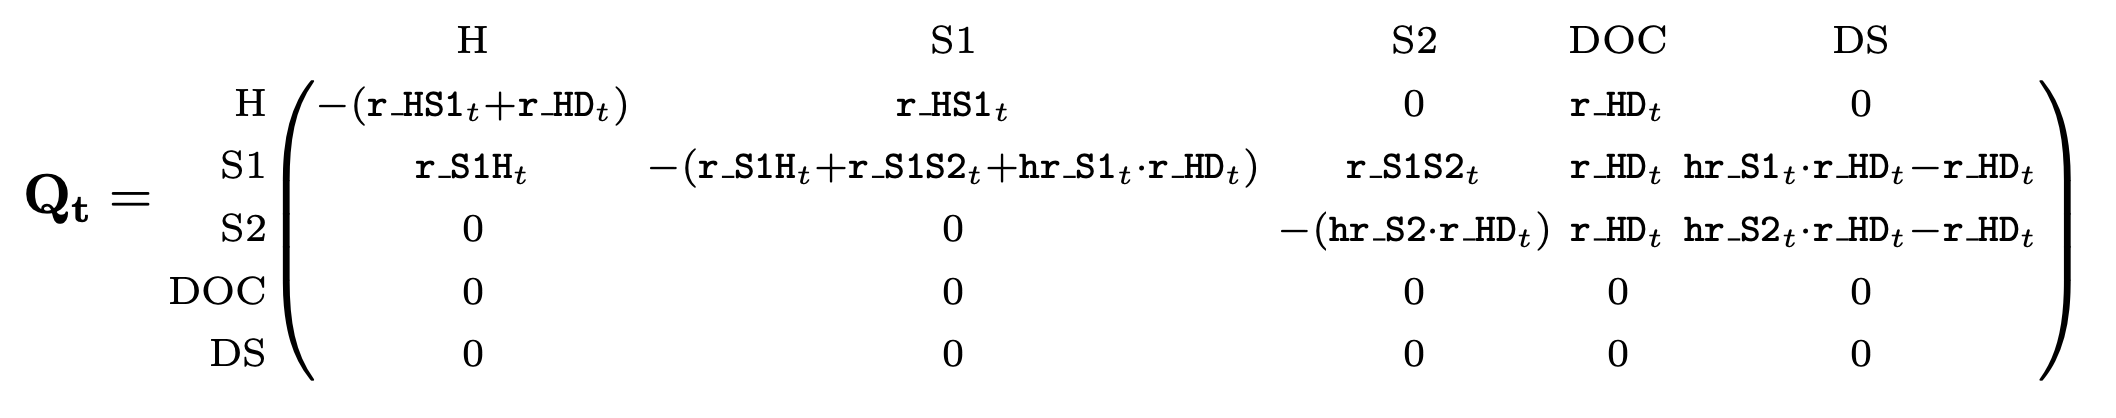
<figcaption aria-hidden="true">Transition Intensity Matrix for Approach 1</figcaption>
</figure>

Cell values in row $i$, column $j$ of $\mathbf{Q}_t$ capture the (continuous time) transition rate from health state $i$ to health state $j$. $\mathbf{Q}_t$ has diagonal elements defined as the negative sum of the off-diagonal row values (i.e., the row sums of $\mathbf{Q}_t$ are zero). This ensures that the Markov model is “closed”—that is, the total cohort size neither grows or shrinks over time.

We next embed the transition intensity matrix into a discrete time transition probability matrix by taking the matrix exponential of $\mathbf{Q}_t$ for a defined cycle length (“time step”) $\Delta t$:[1]

<span id="eq-embed">$$
\mathbf{P}_t = e^{\mathbf{Q}_t\Delta t}
 \qquad(1)$$</span>

Embedding the Sick-Sicker model results in a transition probability matrix $\mathbf{P}_t$ with the following probabilities defined:

<figure>
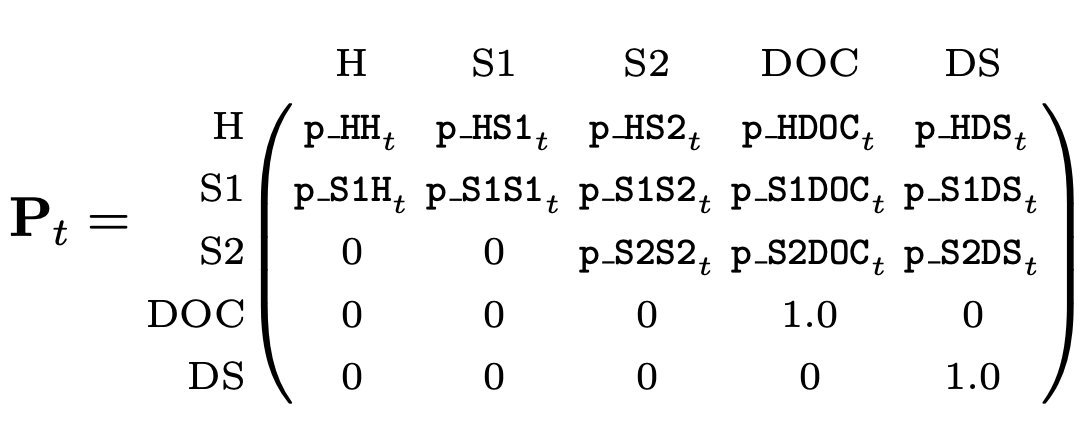
<figcaption aria-hidden="true">Transition Probability Matrix for Approach 1</figcaption>
</figure>

Embedding the transition probability matrix using <a href="#eq-embed" class="quarto-xref">Equation 1</a> ensures that the resulting transition probabilities capture the underlying continuous time disease process. In particular, $\mathbf{P}$ captures the probability of compound (“jumpover”) transitions within a single cycle.[2]

## 1.2 Markov Trace

Define $\mathbf{s}_0$ as the initial state occupancy (column) vector at time $t=0$. The vector $\mathbf{s}_0$ has size $k$, where $k$ is the total number of states . This vector summarizes the number or fraction of the cohort in each health state at baseline. Health state occupancy at time $t$ is is calculated as:

<span id="eq-trace">$$
\mathbf{s}^\top_t=\mathbf{s}^\top_0 \mathbf{P}_1\mathbf{P}_2\dots\mathbf{P}_t
 \qquad(2)$$</span> where $\mathbf{P}_t$ is the $k \times k$ transition probability matrix at time $t$.[3]

We apply <a href="#eq-trace" class="quarto-xref">Equation 2</a> at each cycle to construct a Markov trace $\mathbf{S}$, which has dimensions $\omega \times k$,

<span id="eq-markovtrace">$$
\mathbf{S} = \begin{bmatrix}
s_{01} & s_{02} & \ldots & s_{0k} \\
s_{11} & s_{12} & \ldots & s_{1k} \\
\vdots & \vdots & \ddots & \vdots \\
s_{\omega-1, 1} & s_{\omega-1, 2} & \ldots & s_{\omega-1, k}
\end{bmatrix}
 \qquad(3)$$</span> where each row represents state occupancy at time $t = 0, 1, \ldots, \omega-1$.

Note that the rows in $\mathbf{S}$ run from $t=0$ to $\omega-1$; this assumes that all health state transitions occur at the end of each cycle. If we were to instead assume transitions occur at the beginning of the cycle, we would set the matrix to run from $t=1$ to $\omega$.

## 1.3 Quality-Adjusted Life Years

To calculate QALYs, we define a $k \times 1$ disability weight payoff vector $\mathbf{d}_{QALY}$. For the model as represented in **?@fig-modelDS**, define,

# 2. Advanced Methods

Our final approach adapts methods from mathematical demography to estimate YLD, YLL and DALY outcomes ([Caswell and van Daalen 2021](#ref-caswell2021a)).[4] This approach requires a separate disease-related absorbing state as shown in **?@fig-modelDS**. While our focus here is on expected outcomes, this method can also be used to estimate higher order moments (e.g., variance, skewness). It is also quite flexible and can estimate separate outcomes for any combination of health states and age classes (e.g., disease-free survival among those aged 40-45, etc.); see Caswell and Zarulli ([2018](#ref-caswell2018)) and Caswell and van Daalen ([2021](#ref-caswell2021a)) for details.

To implement Approach 3 we define some additional parameters:

$$
\begin{aligned}
\tau &= \text{Number of transient (non-absorbing) states}\\
\alpha &= \text{Number of absorbing states}\\
\omega &= \text{Number of cycles (age classes)} \\
s &= \text{Total number of states; }s=\tau\omega+\alpha \\
\mathbf{K} &= \text{vec-permutation matrix; parameters }\tau,\omega\\
\mathbf{U}_{t} &= \text{Transition matrix at time }t, \text{for }t=1,\dots,\omega\\
\mathbf{M}_{t} &= \text{Mortality matrix at time  }t, \text{for } t = 1,\dots\omega \\
\mathbf{D}_{j} &=\text{Age advancement matrix for stage }j, \text{for }j=1,\dots,\tau 
\end{aligned}
$$ In the above notation, $\mathbf{K}$ is a permutation matrix known as the vec-permutation matrix.[5] The matrix $\mathbf{U}_t$ captures transition probabilities among transient (i.e., non-absorbing) health states, while $\mathbf{M}_t$ contains transition probabilities from transient health states to the absorbing (death) states.

To construct $\mathbf{U}_t$ and $\mathbf{M}_t$ we define transition rate (“intensity”) matrices as in Approaches 1 and 2 above. One important (minor) difference is that the rows in $\mathbf{Q}_t$, $\mathbf{V}_t$, and $\mathbf{S}_t$ now correspond to the final state, while the columns correspond to the starting state; this is essentially the transpose of the rate matrices defined for Approaches 1 and 2.

The overall intensity matrix $\mathbf{Q}_t$ is given by

<span id="eq-Qx">$$
\mathbf{Q}_t=\left(\begin{array}{c|c}
\mathbf{V}_t & \mathbf{0} \\
\hline \mathbf{S}_t  & \mathbf{0}
\end{array}\right)
 \qquad(4)$$</span> where $\mathbf{V}_t$ is the rate matrix for the transitory (i.e., non-absorbing) states and $\mathbf{S}_t$ is the rate matrix for the absorbing states. The diagonal elements of $\mathbf{Q}_t$ are the negative sum of the non-diagonal column elements, thus making the column sums of $\mathbf{Q}_t$ zero (i.e., the model is “closed” and does not gain or lose cohort members over time).

For the defined time step $\Delta_t$, the discrete time transition probability matrix $\mathbf{P}_t$ is again obtained by taking the matrix exponential of the intensity matrix ($\mathbf{Q}_t$) multiplied by the time step, i.e., <a href="#eq-embed" class="quarto-xref">Equation 1</a>:

$$
\mathbf{P}_t =e^{\mathbf{Q}_t  \Delta t}
$$

We obtain $\mathbf{U}_t$ and $\mathbf{M}_t$ from the block matrix structure of $\mathbf{P}_t$:

<span id="eq-P3">$$
\mathbf{P}_t =\left(\begin{array}{c|c}
\mathbf{U}_t  & \mathbf{0} \\
\hline \mathbf{M}_t  & \mathbf{0}
\end{array}\right)
 \qquad(5)$$</span>

In addition, the matrix $\mathbf{D}_j$ defines age advancement in the model. Borrowing from an example in Caswell and van Daalen ([2021](#ref-caswell2021a)), if $\omega=3$ then

<span id="eq-D">$$
\mathbf{D}_j=\left(\begin{array}{ccc}
0 & 0 & 0 \\
1 & 0 & 0 \\
0 & 1 & {[1]}
\end{array}\right) \quad j=1, \ldots, \tau
 \qquad(6)$$</span>

In our implementation, we include the (optional) value of one in the lower right corner; this assumes that after the last specified age, the cohort continues to experience transitions among health states according to the transition probabilities defined for the last age class. If this value is zero, the model will assume that everyone dies after the last cycle.

We next combine the transition matrices (for all age classes as defined by discrete time cycles) together into a series of block-structured matrices as follows:

<span id="eq-bbU">$$
\mathbb{U}=\left(\begin{array}{c|c|c}
\mathbf{U}_1 & \cdots & \mathbf{0} \\
\hline & \ddots & \\
\hline \mathbf{0} & \cdots & \mathbf{U}_\omega
\end{array}\right)
 \qquad(7)$$</span>

<span id="eq-BBD">$$
\mathbb{D}=\left(\begin{array}{c|c|c}
\mathbf{D}_1 & \cdots & \mathbf{0} \\
\hline & \ddots & \\
\hline \mathbf{0} & \cdots & \mathbf{D}_\tau
\end{array}\right)
 \qquad(8)$$</span>

<span id="eq-Utilde">$$
\widetilde{\mathbf{U}}=\mathbf{K}^{\top} \mathbb{D} \mathbf{K} \mathbb{U} \quad \tau \omega \times \tau \omega
 \qquad(9)$$</span> where $^\top$ is the transpose operator.

We also define

<span id="eq-Mtilde">$$
\widetilde{\mathbf{M}}=\left(\begin{array}{lll}
\mathbf{M}_1 & \cdots & \mathbf{M}_\omega
\end{array}\right) \quad \alpha \times \tau \omega
 \qquad(10)$$</span>

Finally, we capture the entire Markov chain in a block transition matrix,

<span id="eq-Ptilde">$$
\widetilde{\mathbf{P}}=\left(\begin{array}{c|c}
\widetilde{\mathbf{U}} & \mathbf{0}_{\tau \omega \times \alpha} \\
\hline \widetilde{\mathbf{M}} & \mathbf{I}_{\alpha \times \alpha}
\end{array}\right) \quad(\tau \omega+\alpha) \times(\tau \omega+\alpha)
 \qquad(11)$$</span> where $\mathbf{I}$ is the identity matrix and $\mathbf{0}$ is a matrix of zeros.

$\widetilde{\mathbf{P}}$ is the analogue to the transition matrix $\mathbf{P}_t$ (<a href="#eq-embed" class="quarto-xref">Equation 1</a>) under Approaches 1 and 2 above.

## 2.1 DALY Outcomes

Our advanced approach draws on Markov chain with rewards methods that define reward matrices for occupancy-based (YLD) and transition-based (YLL) outcomes. These reward matrices allow us to estimate outcomes for any combination of health states and/or ages. Reward matrices have notation $\mathbf{R}_m$, where $m$ indexes the moment of interest (e.g., expected value, variance, etc.). We focus here on expected outcomes (i.e., outcomes based on $\mathbf{R}_1$)—though equations for higher-order moments are available in Caswell and van Daalen ([2021](#ref-caswell2021a)).

### 2.1.1 Years of Life Lived With Disease (YLD)

To estimate YLDs, we first define a $\tau \times \omega$ reward matrix $\mathbf{H}$, which has dimensions $\tau \times \omega$ and is structured as shown in <a href="#fig-H-le" class="quarto-xref">Figure 2</a>:

<figure id="fig-H-le">
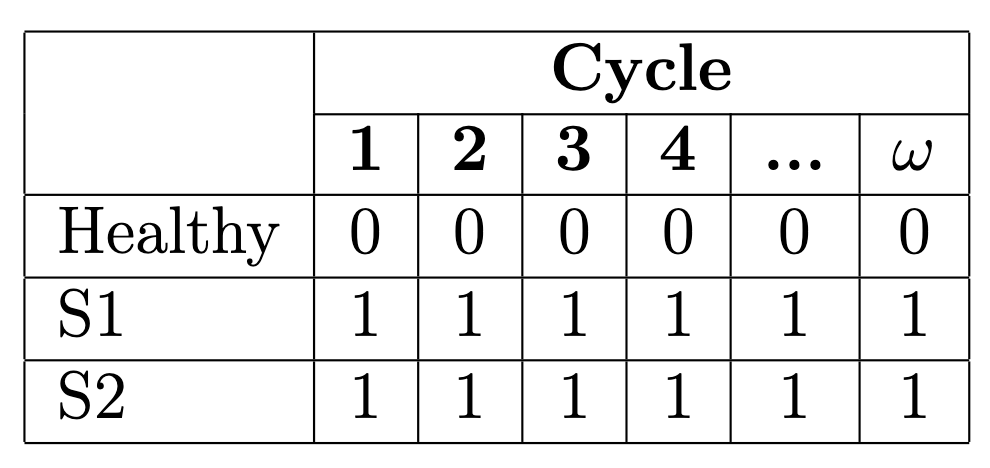
<figcaption>Figure 2: YLD reward matrix <span class="math inline">\(\mathbf{H}\)</span></figcaption>
</figure>

Cell values within this matrix can be set to one if we want to potentially “reward” that health state-age combination in our outcome measure, and zero otherwise.

We use this matrix to define the reward vector $\mathbf{h}$, where $\text{vec}$ is an operator that stacks the columns of an $m \times n$ matrix into a $mn \times 1$ vector.

$$
\mathbf{h} = \text{vec } \mathbf{H}
$$ We also define $\neg \mathbf{h}$ as the complement of $\mathbf{h}$, (i.e., values of 1.0 become 0, and vice versa).

We next define additional matrix $\mathbf{V}$, which has the same structure as $\mathbf{H}$ but includes the (fully discounted) disability weights:

<figure id="fig-H-yld">
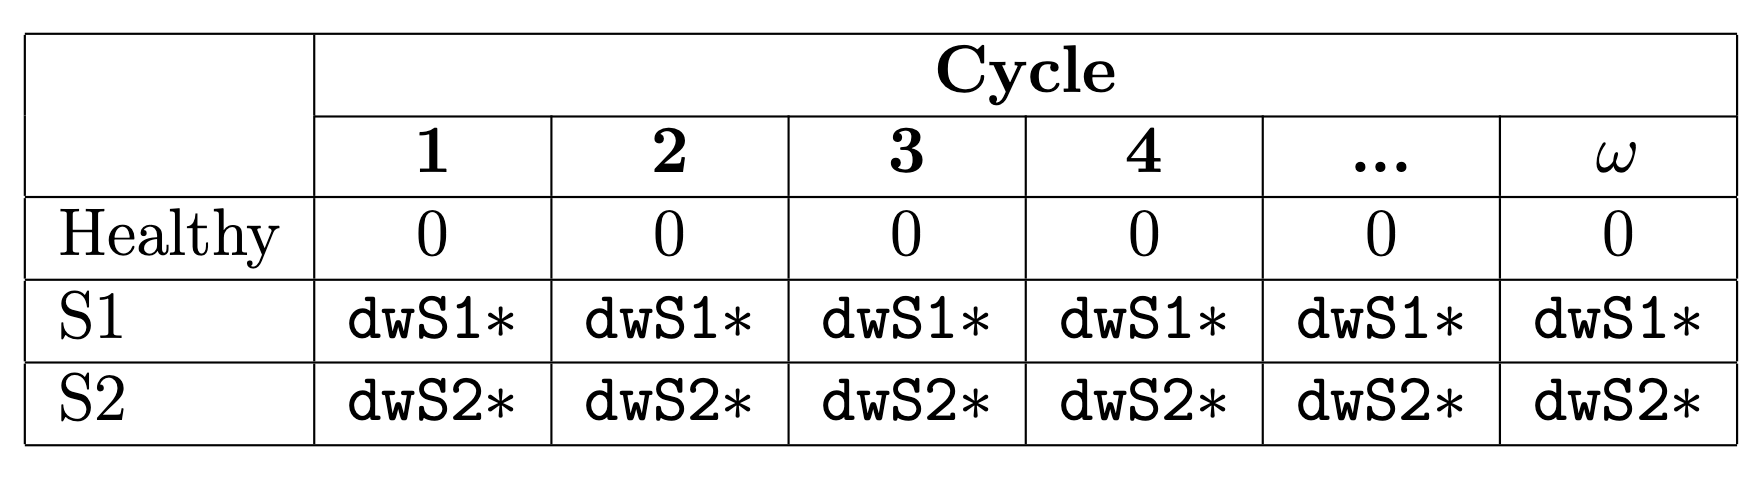
<figcaption>Figure 3: YLD reward matrix <span class="math inline">\(\mathbf{V}\)</span></figcaption>
</figure>

where $\texttt{dwS1}* = \texttt{dwS1} \times \Delta_t \times \frac{1}{r_{\Delta_t}}(1-e^{-r_{\Delta_t}}) \times e^{-r_{\Delta_t} t}$, etc. This equation first converts the weights into the appropriate value for the time step, applies the cycle-specific discounting adjustment factor, and then discounts the resulting value to the baseline period.

We similarly define an occupancy indicator vector $\mathbf{v}$ just as we did for $\mathbf{h}$:

$$
\mathbf{v}=\operatorname{vec} \mathbf{V}
$$

#### 2.1.1.1 Partial Occupancy

Because we are modeling a continuous-time disease progression progress in discrete time, it is useful to make corrections for partial occupancy in a cycle. Similar to a half-cycle correction often used in health economic applications, the Markov chain with rewards approach does so by assuming transitions occur half-way through a cycle; the application of this assumption is slightly different, however, because the correction applies in every cycle, not just the first and last. We operationalize this assumption by defining,

$$
\begin{aligned}
\widetilde{\mathbf{B}}_{1} & =\mathbf{h} \mathbf{v}_{1}^{\top}+\frac{1}{2}(\neg \mathbf{h})\left(\mathbf{v}_{1}^{\top}\right)+\frac{1}{2}\left(\mathbf{v}_{1}\right)\left(\neg \mathbf{h}^{\top}\right) \\
\end{aligned}
$$ and

$$
\widetilde{\mathbf{C}}_{1}=\frac{1}{2} \mathbf{1}_{\alpha} \mathbf{v_1}^{\top}
$$ where $\mathbf{1}_{\alpha}$ is a vector of ones with length $\alpha$.

We combine $\widetilde{\mathbf{B}}_{1}$ and $\widetilde{\mathbf{C}}_{1}$ to obtain the final reward matrix for expected YLD outcomes,

$$
\widetilde{\mathbf{R}}^{YLD}_{1}=\left(\begin{array}{c|c}
\widetilde{\mathbf{B}}_{1} & \mathbf{0} \\
\hline \widetilde{\mathbf{C}}_{1} & \mathbf{0}
\end{array}\right) 
$$ which has same block structure and dimensions as the transition probability matrix $\widetilde{\mathbf{P}}$ (<a href="#eq-Ptilde" class="quarto-xref">Equation 11</a>). We explain how to use this matrix to estimate expected YLDs in <a href="#sec-expected" class="quarto-xref">Section 2.1.3</a> below.

### 2.1.2 Years of Life Lost to Disease (YLL)

For transition-based outcomes such as YLLs, we define the first moment of remaining life expectancy as the vector $\widetilde{\boldsymbol{\eta}}^{\top}$. This vector has dimensions $\tau\omega \times 1$ and has the following basic structure:

$$
\widetilde{\mathbf{\eta}}=\left(\begin{array}{c}
\eta_{11} \\
\vdots \\
\eta_{\tau 1} \\
\hline \vdots \\
\hline \eta_{1 \omega} \\
\vdots \\
\eta_{\tau \omega}
\end{array}\right)
$$ where $\eta_{i x}$ is remaining life expectancy for an individual in health state $i$ at a given age $x$. In this structure, remaining life expectancy for each health state is grouped within age classes. Remaining life expectancy should also enter $\eta_{i x}$ as fully discounted back to $t=0$.

Our model, for example, follows a cohort of 25 year old adults until death. The GBD reference life expectancy value for a 25 year old is 64.15, and the life expectancy for the last age class (95+) is 5.92. There are also $\tau=3$ non-absorbing health states. If we followed the cohort until age 95, $\eta_{i x}$ would take the following form:

$$
\widetilde{\mathbf{\eta}}=\left(\begin{array}{c}
\eta_{H,25} =  64.15 \\
\eta_{S1,25} =  64.15 \\
\eta_{S2,25} =  64.15 \\
\hline \vdots \\
\hline \eta_{H,95} =  5.92 \\
\eta_{S1,95} = 5.92 \\
\eta_{S2,95} =  5.92 \\
\end{array}\right)
$$

We next construct the reward matrices:

$$
\begin{aligned}
\widetilde{\mathbf{B}}_{1} & =\left(\mathbf{0}_{\tau \omega \times \tau \omega}\right) \\
\widetilde{\mathbf{C}}_{1} & =\left(\begin{array}{c}
\widetilde{\boldsymbol{\eta}}_{1}^{\top} \\
\mathbf{0}_{1 \times \tau \omega}
\end{array}\right) .
\end{aligned}
$$

and

$$
\widetilde{\mathbf{R}}^{YLL}_{1}=\left(\begin{array}{c|c}
\mathbf{0}_{\tau \omega \times \tau \omega} & \mathbf{0}_{\tau \omega \times 2} \\
\hline \widetilde{\boldsymbol{\eta}}_{1}^{\top} & \mathbf{0}_{1 \times 2} \\
\mathbf{0}_{1 \times \tau \omega} & \mathbf{0}_{1 \times 2}
\end{array}\right)
$$

### 2.1.3 Expected YLD and YLL Outcomes

The expected value of outcome $Y$ (where $Y \in \{YLD, YLL\}$) is estimated by,

<span id="eq-app3out">$$
\begin{aligned}
& \widetilde{\boldsymbol{\rho}}^{Y}_{1}=\widetilde{\mathbf{N}}^{\top} \mathbf{Z}\left(\widetilde{\mathbf{P}} \odot \widetilde{\mathbf{R}}^Y_{1}\right)^{\top} \mathbf{1}_{s} 
\end{aligned}
 \qquad(12)$$</span> where $\widetilde{\mathbf{N}}$ is the fundamental matrix,

$$
\widetilde{\mathbf{N}}=(\mathbf{I}-\widetilde{\mathbf{U}})^{-1}
$$ and $\mathbf{Z}$ is

$$
\mathbf{Z}=\left(\mathbf{I}_{\tau \omega} \mid \mathbf{0}_{\tau \omega \times \alpha}\right)
$$

Total (across all ages) outcomes for each starting health state are calculated as

<span id="eq-app3outstate">$$
\boldsymbol{\rho}_{1}^{Y,\text {stage }}(\operatorname{cycle } t)=\left(\mathbf{e}_{t}^{\top} \otimes \mathbf{I}_{\tau}\right) \widetilde{\boldsymbol{\rho}}^Y_{1} \quad \tau \times 1
 \qquad(13)$$</span> where $\otimes$ is the Kronecker operator and $\mathbf{e}_{t}$ is a vector of length $\omega$ with a value of one in the first position and zero elsewhere; this facilitates calculating expected outcomes from the baseline period (i.e., $t=0$).

<a href="#eq-app3outstate" class="quarto-xref">Equation 13</a> will yield expected outcomes as typically reported in health economic evaluations. Alternatively, we may wish to calculate outcomes separately under different baseline age-health state combinations (e.g., DALYs for healthy 55 year-old adults). We obtain these expected outcomes by,

<span id="eq-app3outage">$$
\boldsymbol{\rho}_{1}^{Y,\text {age }}(\text { stage } i)=\left(\mathbf{I}_{\omega} \otimes \mathbf{e}_{i}^{\top}\right) \widetilde{\boldsymbol{\rho}}^Y_{1} \quad \omega \times 1,
 \qquad(14)$$</span> where $\mathbf{e}_{i}$ is a vector of length $\tau$ with a value of one in the initial health state position of interest (e.g., `Healthy`) and zero elsewhere.

[1] In Markov theory, $\mathbf{P}$ is called the “discrete skeleton” of the continuous model ([Iosifescu 1980](#ref-iosifescu1980)). The conversion formula used to calculate $mathbf{P}$ is the matrix analogue to the standard rate-to-probability formula commonly taught in health economics textbooks, i.e., $p = 1 - e^{r\Delta t}$, where $r$ is the rate and $\Delta t$ is the time step (i.e., “cycle length”).

[2] For example, in the continuous time rate matrix $\mathbf{Q}_t$ above, there is a zero-valued rate defined for progressions from Healthy (H) to Disease-related death (DS), since individuals must first become ill before they can die from disease-related causes. However, after embedding, the matrix $\mathbf{P}$ has a non-zero cycle transition probability from Healthy (H) to Disease-related death (DS) (i.e., $\texttt{p\_HDS}$). This value captures the probability of a compound or “jumpover” transition from Healthy and through the Sick and/or Sicker state to death from disease-related causes within the same discrete time cycle; see Graves et al. ([2021](#ref-graves2021)) for further discussion, and Iosifescu ([1980](#ref-iosifescu1980)) for additional theory.\[^comparison\]

[3] For a time-homogeneous model, <a href="#eq-trace" class="quarto-xref">Equation 2</a> simplifies to $\mathbf{s}^\top_t=\mathbf{s}^\top_0 \mathbf{P}^t$.

[4] The method also easily accommodates other common outcomes such as QALYs and costs.

[5] See Henderson and Searle ([1981](#ref-henderson1981)) and Appendix B in Caswell and van Daalen ([2021](#ref-caswell2021a)) for further information. A function to construct a vec-permutation matrix is provided within our replication code.

In [ ]:
params_adv_ <- with(params,modifyList(params_int,list(
    alpha = length(v_ab_names),
    tau = length(v_tr_names), 
    s = length(v_tr_names)*omega + length(v_ab_names) #total number of states;s=τω+α
)))

# approach 3 requires us to transpose transition intensity matrices from approaches 1 & 2 
params_adv_ <- with(params_adv_,modifyList(params_adv_,list(
  m_R_t = m_R %>% map(~({
    tmp <- .x
    tmp %>% map(~(t(.x)))
  }))
)))

# not sure why this is needed, but otherwise the length gets set too long...
params_adv <- with(params_adv_, modifyList(params_adv_, list(m_R_t_ = m_R_t %>% transpose())))
params_adv$m_R_t = params_adv$m_R_t_

params_adv <- with(params_adv,modifyList(params_adv,list(
    mV = m_R_t %>% map(~({
            R = .x
            R %>% map(~({
              m <- .x[v_tr_names,v_tr_names] 
            }))
            
        })),
     
    mQ = m_R_t %>% map(~({
      R = .x 
      R %>% map(~({
                V = .x[v_tr_names,v_tr_names]
                S = .x[v_ab_names,v_tr_names]
                zero_ <- matrix(0, nrow = length(v_tr_names)+length(v_ab_names), ncol = length(v_ab_names))
                tmp <- cbind(rbind(V,S),zero_)
                dimnames(tmp) <- list(c(v_tr_names,v_ab_names),c(v_tr_names,v_ab_names))
                tmp
      }))
    }))    
)))

params_adv <- with(params_adv,modifyList(params_adv,list(
    mP = mQ %>% map(~({
          Q = .x
          Q %>% map(~(expm(.x * Delta_t)))
    }))
)))

params_adv <- with(params_adv,modifyList(params_adv,list(
    mU = mP %>% map(~({
          P <- .x 
          P %>% map(~(.x[v_tr_names,v_tr_names]))
    })),
    mM = mP %>% map(~({
        P = .x
        P %>% map(~(.x[v_ab_names,v_tr_names]))
        
    }))
)))

params_adv <- with(params_adv,modifyList(params_adv,list(
    D = {
        # Create diagonal age advancement matrix
        D <- matrix(0, omega, omega)
        vec <- rep(1, omega-1)
        D[row(D)-1 == col(D)] <- vec
        # UNCOMMENT IF YOU WANT TO GET FULL EXPECTED VALUE 
        #D[omega,omega] = 1
        D
    }
)))

vec <-  # a simple function to return the vec of an array
    function(x) {
        y <- c(x)
        return(y)
    }

vecperm <- 
    # vecperm
    # function to calculate the vec permutation matrix K of index m,n
    # let X be a m x n matrix, and X' the transpose of X
    # then K satisfies 
    # vec(X') = K*vec(X)
    function(m, n) {
        K <- matrix(0, m * n, m * n)
        a <- matrix(0, m, n)
        
        for (i in 1:m) {
            for (j in 1:n) {
                e <- a
                e[i, j] <- 1
                K <- K + kronecker(e, t(e))
            }
        }
        
        return(K)
    }

params_adv <- with(params_adv,modifyList(params_adv,list(
    bbD_ = kronecker(diag(tau), D),
    bbU_ =  mU %>% 
            map(~(bdiag(.x))),
    K = vecperm(tau, omega)
)))

params_adv <- with(params_adv,modifyList(params_adv,list(
    mUtilde = bbU_ %>% map( ~ ({
        t(K) %*% bbD_ %*% K %*% .x
    }))
)))

params_adv <- with(params_adv,modifyList(params_adv,list(
    mMtilde = mM %>% map(~({
      do.call(cbind,.x) 
    }))  
)))

params_adv <- with(params_adv,modifyList(params_adv,list(
    mPtilde =  map2(mUtilde, mMtilde,  ~ ({
            rbind(cbind(.x, matrix(0, tau * omega, alpha)) ,
                  cbind(.y, diag(alpha)))
        }))
)))

mcwr_occupancy <- function(params, H, V) {
  with(params,{
    map(v_tx_names,~({
      U = mUtilde[[.x]]
      P = mPtilde[[.x]]
      v_ = V[[.x]]
      N = solve(diag(tau*omega)-U)
      h = vec(H) %>% as.matrix()
      not_h = 1-h
      v <- vec(v_) %>% as.matrix()
      B1 <- h %*% t(v) + 0.5 * (not_h %*% t(v)) + 0.5 * (v %*% t(not_h)) # Eq. 46
      C1 = 0.5 * (rep(1,alpha) %*%  t(v)) # Eq. 48
      R1 = rbind(cbind(B1, matrix(0, tau * omega, alpha)) ,
                 cbind(C1, diag(alpha))) 
      R2 = R1 * R1
      R3 = R1 * R1 * R1
      Z = cbind(diag(tau*omega),matrix(0,nrow=tau*omega, ncol=alpha))
      e = rep(1,s)
      rho1_ <- t(N)%*% Z %*% t(P * R1) %*% e
      rho1_
    }))
  })
}

mcwr_yll <- function(params, life_expectancy, disc) {
  with(params,{
    map2(mUtilde,mPtilde,~({
      U = .x
      P = .y
      N = solve(diag(tau*omega)-U)
      Z = cbind(diag(tau*omega),matrix(0,nrow=tau*omega, ncol=alpha))
      disc_ = rev(sort(rep(disc,length(v_tr_names))))
      eta1_ex_ = rev(sort(rep(life_expectancy,length(v_tr_names))))
      eta1_ex =  eta1_ex_
      
      B1 = matrix(0,nrow=tau*omega, ncol = tau*omega)
      C1 = rbind(matrix(0,nrow=1,ncol=tau*omega),eta1_ex*disc_) 
      R1 = cbind(rbind(B1,C1),matrix(0,nrow=tau*omega+2,ncol=2))
      R2 = R1 * R1
      R3 = R1 * R1 * R1
      Z = cbind(diag(tau*omega),matrix(0,nrow=tau*omega, ncol=alpha))
      e = rep(1,s)
      rho1_ = t(N) %*% Z %*% t(.y * R1) %*% e
      rho1_
    }))
  })
}
H = with(params_adv,matrix(1,nrow=tau, ncol=omega))

with(params_adv,{
  V_LY <<- v_tx_names %>% map(~({
    v_ <- matrix(1,nrow=tau, ncol = omega) 
    v_
  })) %>% 
    set_names(v_tx_names)
})

with(params_adv,{
  V_YLD <<- v_tx_names %>% map(~({
    v_ <- matrix(0,nrow=tau, ncol = omega) 
    v_[2,] <- v_discC_h[-1]*dw_S1 * Delta_t * (1/r_v_disc_h_Delta_t) * (1 - exp(-r_v_disc_h_Delta_t))
    v_[3,] <- v_discC_h[-1]*dw_S2 * Delta_t * (1/r_v_disc_h_Delta_t) * (1 - exp(-r_v_disc_h_Delta_t))
    if (.x %in% c("A","AB")) {
      v_[2,] <- v_discC_h[-1]*dw_trtA * Delta_t * (1/r_v_disc_h_Delta_t) * (1 - exp(-r_v_disc_h_Delta_t))
    }
    v_
  })) %>% 
    set_names(v_tx_names)
})

with(params_adv,{
  V_QALY <<- v_tx_names %>% map(~({
    v_ <- matrix(0,nrow=tau, ncol = omega) 
    v_[1,] <- v_discC_h[-1]*u_H * Delta_t     
    v_[2,] <- v_discC_h[-1]*u_S1 * Delta_t 
    v_[3,] <- v_discC_h[-1]*u_S2 * Delta_t 
    if (.x %in% c("A","AB")) {
      v_[2,] <- v_discC_h[-1]*u_trtA * Delta_t 
    }
    v_
  })) %>% 
    set_names(v_tx_names)
})


with(params_adv,{
  V_COST <<- v_tx_names %>% map(~({
    v_ <- matrix(0,nrow=tau, ncol = omega) 
    v_[1,] <- v_discC_c[-1]*c_H * Delta_t     
    v_[2,] <- v_discC_c[-1]*c_S1 * Delta_t 
    v_[3,] <- v_discC_c[-1]*c_S2 * Delta_t 
    if (.x %in% c("A")) {
      v_[2,] <- v_discC_c[-1]*(c_S1 + c_trtA) * Delta_t 
      v_[3,] <- v_discC_c[-1]*(c_S2 + c_trtA) * Delta_t  
    }
    if (.x %in% c("B")) {
      v_[2,] <- v_discC_c[-1]*(c_S1 + c_trtB) * Delta_t 
      v_[3,] <- v_discC_c[-1]*(c_S2 + c_trtB) * Delta_t  
    }    
    if (.x %in% c("AB")) {
      v_[2,] <- v_discC_c[-1]*(c_S1 + c_trtA + c_trtB) * Delta_t 
      v_[3,] <- v_discC_c[-1]*(c_S2 + c_trtA + c_trtA) * Delta_t  
    }    
    v_
  })) %>% 
    set_names(v_tx_names)
})

LY3_ <- params_adv %>% mcwr_occupancy(H = H, V = V_LY)
QALY3_ <- params_adv %>% mcwr_occupancy(H = H, V = V_QALY)
HYLD = H
HYLD[1,] = rep(0,ncol(H))
YLD3_ <- params_adv %>% mcwr_occupancy(H = HYLD, V = V_YLD)
COST3_ <- params_adv %>% mcwr_occupancy(H = H, V = V_COST)

remaining_life_expectancy <- 
  with(params_adv,(1/r_v_disc_h) * (1 - exp(-r_v_disc_h * f_ExR(ages+1))))

YLL3_ <- params_adv %>% mcwr_yll(life_expectancy = remaining_life_expectancy, disc = v_discC_h[-1])
DALY3_ <- map2(YLL3_,YLD3_,~(.x+.y))

LY3 <- LY3_ %>% map(~({
  tmp <- (kronecker(t(c(1,rep(0,params_adv$omega-1))) ,diag(params_adv$tau)) %*% as.matrix(.x))
  tmp[1,1]
}))

QALY3 <- QALY3_ %>% map(~({
  tmp <- (kronecker(t(c(1,rep(0,params_adv$omega-1))) ,diag(params_adv$tau)) %*% as.matrix(.x))
  tmp[1,1]
}))

YLD3 <- YLD3_ %>% map(~({
  tmp <- (kronecker(t(c(1,rep(0,params_adv$omega-1))) ,diag(params_adv$tau)) %*% as.matrix(.x))
  tmp[1,1]
}))

YLL3 <- YLL3_ %>% map(~({
  tmp <- (kronecker(t(c(1,rep(0,params_adv$omega-1))) ,diag(params_adv$tau)) %*% as.matrix(.x))
  tmp[1,1]
}))

DALY3 <- DALY3_ %>% map(~({
  tmp <- (kronecker(t(c(1,rep(0,params_adv$omega-1))) ,diag(params_adv$tau)) %*% as.matrix(.x))
  tmp[1,1]
}))

COST3 <- COST3_ %>% map(~({
  tmp <- (kronecker(t(c(1,rep(0,params_adv$omega-1))) ,diag(params_adv$tau)) %*% as.matrix(.x))
  tmp[1,1]
}))

result_adv <- cbind(LY3, YLD3, YLL3, DALY3, QALY3,COST3) %>%
  as.data.frame() %>%
  rename(LY = LY3, YLD = YLD3, YLL = YLL3, DALY = DALY3, QALY = QALY3, COST = COST3) %>% 
  mutate_all( ~ as.numeric(.))  %>%
  rownames_to_column(var = "strategy") %>%
  mutate(approach = "Markov Chain With Rewards") %>% 
  dplyr::select(approach, strategy, everything())

In [ ]:
cea <- 
  bind_rows(
    dampack::calculate_icers(cost = result_ref$COST, effect = result_ref$QALY, strategies = result_ref$strategy) %>% 
      mutate(approach = "Traditional")
  ) %>% 
  bind_rows(
    dampack::calculate_icers(cost = result_int$COST, effect = result_int$QALY, strategies = result_int$strategy) %>% 
      mutate(approach = "Embedded")
  ) %>% 
  bind_rows(
    dampack::calculate_icers(cost = result_adv$COST, effect = result_adv$QALY, strategies = result_adv$strategy) %>% 
      mutate(approach = "Matrix")
  ) %>% 
  
  mutate_at(vars(ICER,Inc_Cost,Cost), ~case_when(Status=="ND" & is.na(.)~"ref.", 
                                                  Status=="D" & is.na(.) ~ "D", 
                                                  .default=as.character(prettyNum(round(.,0), big.mark=",")))) %>% 
  mutate_at(vars(Inc_Effect,Effect), ~case_when(Status=="ND" & is.na(.)~"ref.", 
                                                  Status=="D"& is.na(.) ~ "D" , 
                                                  .default=as.character(prettyNum(round(.,2), big.mark=","))))  %>% 
  select(approach,Strategy,Cost,Inc_Cost,Effect,Inc_Effect,ICER)

cea %>% flextable()

approach,Strategy,Cost,Inc_Cost,Effect,Inc_Effect,ICER
Traditional,SoC,"151,580",ref.,20.71,ref.,ref.
Traditional,B,"259,100","107,521",22.18,1.47,"72,988"
Traditional,AB,"378,875","119,775",23.14,0.95,"125,764"
Traditional,A,"284,805",D,21.5,D,D
Embedded,SoC,"147,037",ref.,21.02,ref.,ref.
Embedded,B,"243,650","96,613",22.57,1.54,"62,581"
Embedded,AB,"353,744","110,094",23.42,0.86,"128,681"
Embedded,A,"271,908",D,21.73,D,D
Matrix,SoC,"140,717",ref.,20.92,ref.,ref.
Matrix,B,"232,415","91,698",22.38,1.46,"62,604"


# 3. Extra Results

In [ ]:
library(directlabels)

p1 = YLL3_ %>% map(~({
  as.data.frame(kronecker(diag(params_adv$omega),t(c(1,0,0))) %*% as.matrix(.x)) %>% 
  mutate(age = params_adv$ages)  %>% 
  mutate(initial = params_adv$v_tr_names[1])
})) %>% 
  set_names(params_adv$v_tx_names) %>% 
  bind_rows(.id = "strategy") %>% 
  filter(age<=100) %>% 
  ggplot(aes(x = age, y = V1, colour = strategy, lty=strategy)) + geom_line(lwd=1) + theme_ipsum() + 
  scale_colour_aaas() + 
  geom_dl(method = list("first.points","bumpup", hjust=-1),aes(label = strategy)) +
    theme(legend.position = "none") +  labs(x = "Age", y = "YLL")

p2 = YLD3_ %>% map(~({
  as.data.frame(kronecker(diag(params_adv$omega),t(c(1,0,0))) %*% as.matrix(.x)) %>% 
  mutate(age = params_adv$ages)  %>% 
  mutate(initial = params_adv$tr_names[1])
})) %>% 
  set_names(params_adv$v_tx_names) %>% 
  bind_rows(.id = "strategy") %>% 
    filter(age<=100) %>% 
  ggplot(aes(x = age, y = V1, colour = strategy, lty=strategy)) + geom_line(lwd=1) + theme_ipsum() + 
  scale_colour_aaas() + 
  geom_dl(method = list("first.points","bumpup", hjust=-1),aes(label = strategy))  + 
  theme(legend.position = "none") + labs(x = "Age", y = "YLD")

p3 = DALY3_ %>% map(~({
  as.data.frame(kronecker(diag(params_adv$omega),t(c(1,0,0))) %*% as.matrix(.x)) %>% 
  mutate(age = params_adv$ages)  %>% 
  mutate(initial = params_adv$tr_names[1])
})) %>% 
  set_names(params_adv$v_tx_names) %>% 
  bind_rows(.id = "strategy") %>% 
  filter(age<=100) %>% 
  ggplot(aes(x = age, y = V1, colour = strategy, lty=strategy)) + geom_line(lwd=1) + theme_ipsum() + 
  scale_colour_aaas() + 
  geom_dl(method = list("first.points","bumpup", hjust=0,vjust=0),aes(label = strategy))  + 
  theme(legend.position = "none") +  labs(x = "Age", y = "DALY")

p4 = COST3_ %>% map(~({
  as.data.frame(kronecker(diag(params_adv$omega),t(c(1,0,0))) %*% as.matrix(.x)) %>% 
  mutate(age = params_adv$ages)  %>% 
  mutate(initial = params_adv$tr_names[1])
})) %>% 
  set_names(params_adv$v_tx_names) %>% 
  bind_rows(.id = "strategy") %>% 
    filter(age<=100) %>% 
  ggplot(aes(x = age, y = V1, colour = strategy, lty=strategy)) + geom_line(lwd=1) + theme_ipsum() + 
  scale_colour_aaas() + 
  geom_dl(method = list("first.points","bumpup", hjust=0,vjust=0),aes(label = strategy))  + 
  theme(legend.position = "none") +  labs(x = "Age", y = "Cost")

## 3.1 Total Cost Decomposition (Newborn Cohort)

In [ ]:
total_costs = COST3_ %>% map(~({
  as.data.frame(kronecker(diag(params_adv$omega),t(c(1,0,0))) %*% as.matrix(.x)) %>%
    mutate(age = params_adv$ages)  %>%
    mutate(initial = params_adv$tr_names[1])
})) %>%
  set_names(params_adv$v_tx_names) %>%
  bind_rows(.id = "strategy") %>%
  as_tibble() %>%
  filter(age == params_adv$age0)

# Now we want to decompose this by age -- that is, when do these costs accrue?
accumulating_costs <-
  1:params_adv$omega %>% map( ~ ({
    H_ = with(params_adv, matrix(0, nrow = tau, ncol = omega))
    H_[, .x] <- rep(1, params_adv$tau)
    V_COST_ = V_COST %>% map( ~ (.x * H_))
    res <-  params_adv %>% mcwr_occupancy(H = H_, V = V_COST_)
    res %>% map( ~ ({
      as.data.frame(kronecker(diag(params_adv$omega), t(c(1, 0,0))) %*% as.matrix(.x)) %>%
        mutate(age = params_adv$ages)  %>%
        mutate(initial = params_adv$tr_names[1])
    })) %>%
      set_names(params_adv$v_tx_names) %>%
      bind_rows(.id = "strategy") %>%
      as_tibble() %>%
      filter(age == params_adv$age0) %>%
      mutate(age = params_adv$ages[.x])
  }))

totals <- 
  accumulating_costs %>%
  bind_rows() %>%
  arrange(strategy,age) %>%
  group_by(strategy) %>%
  mutate(total_costs = sum(V1))  %>%
  mutate(cumsum = cumsum(V1)) %>%
  filter(age<=100) %>% 
  select(strategy,total_costs)  %>% 
  unique() 

p_decomp_cost <- 
  accumulating_costs %>%
  bind_rows() %>%
  arrange(strategy,age) %>%
  group_by(strategy) %>%
  mutate(total_costs = sum(V1))  %>%
  mutate(cumsum = cumsum(V1)) %>%
  filter(age<=100) %>%
  ggplot(aes(x = age, y = cumsum, colour = strategy)) + geom_line(aes(colour = strategy),lwd=1.25) +
  theme_ipsum() +
  scale_colour_aaas() +
  scale_x_continuous(expand = c(0,0)) +
  geom_dl(method = list("last.points","bumpup", hjust=1),aes(label = strategy)) +
  theme(legend.position = "none") +  labs(x = "Age", y = "Total Cost") + 
  geom_hline(data = totals, aes(yintercept = total_costs, colour = strategy),lty=1,alpha = 0.5)

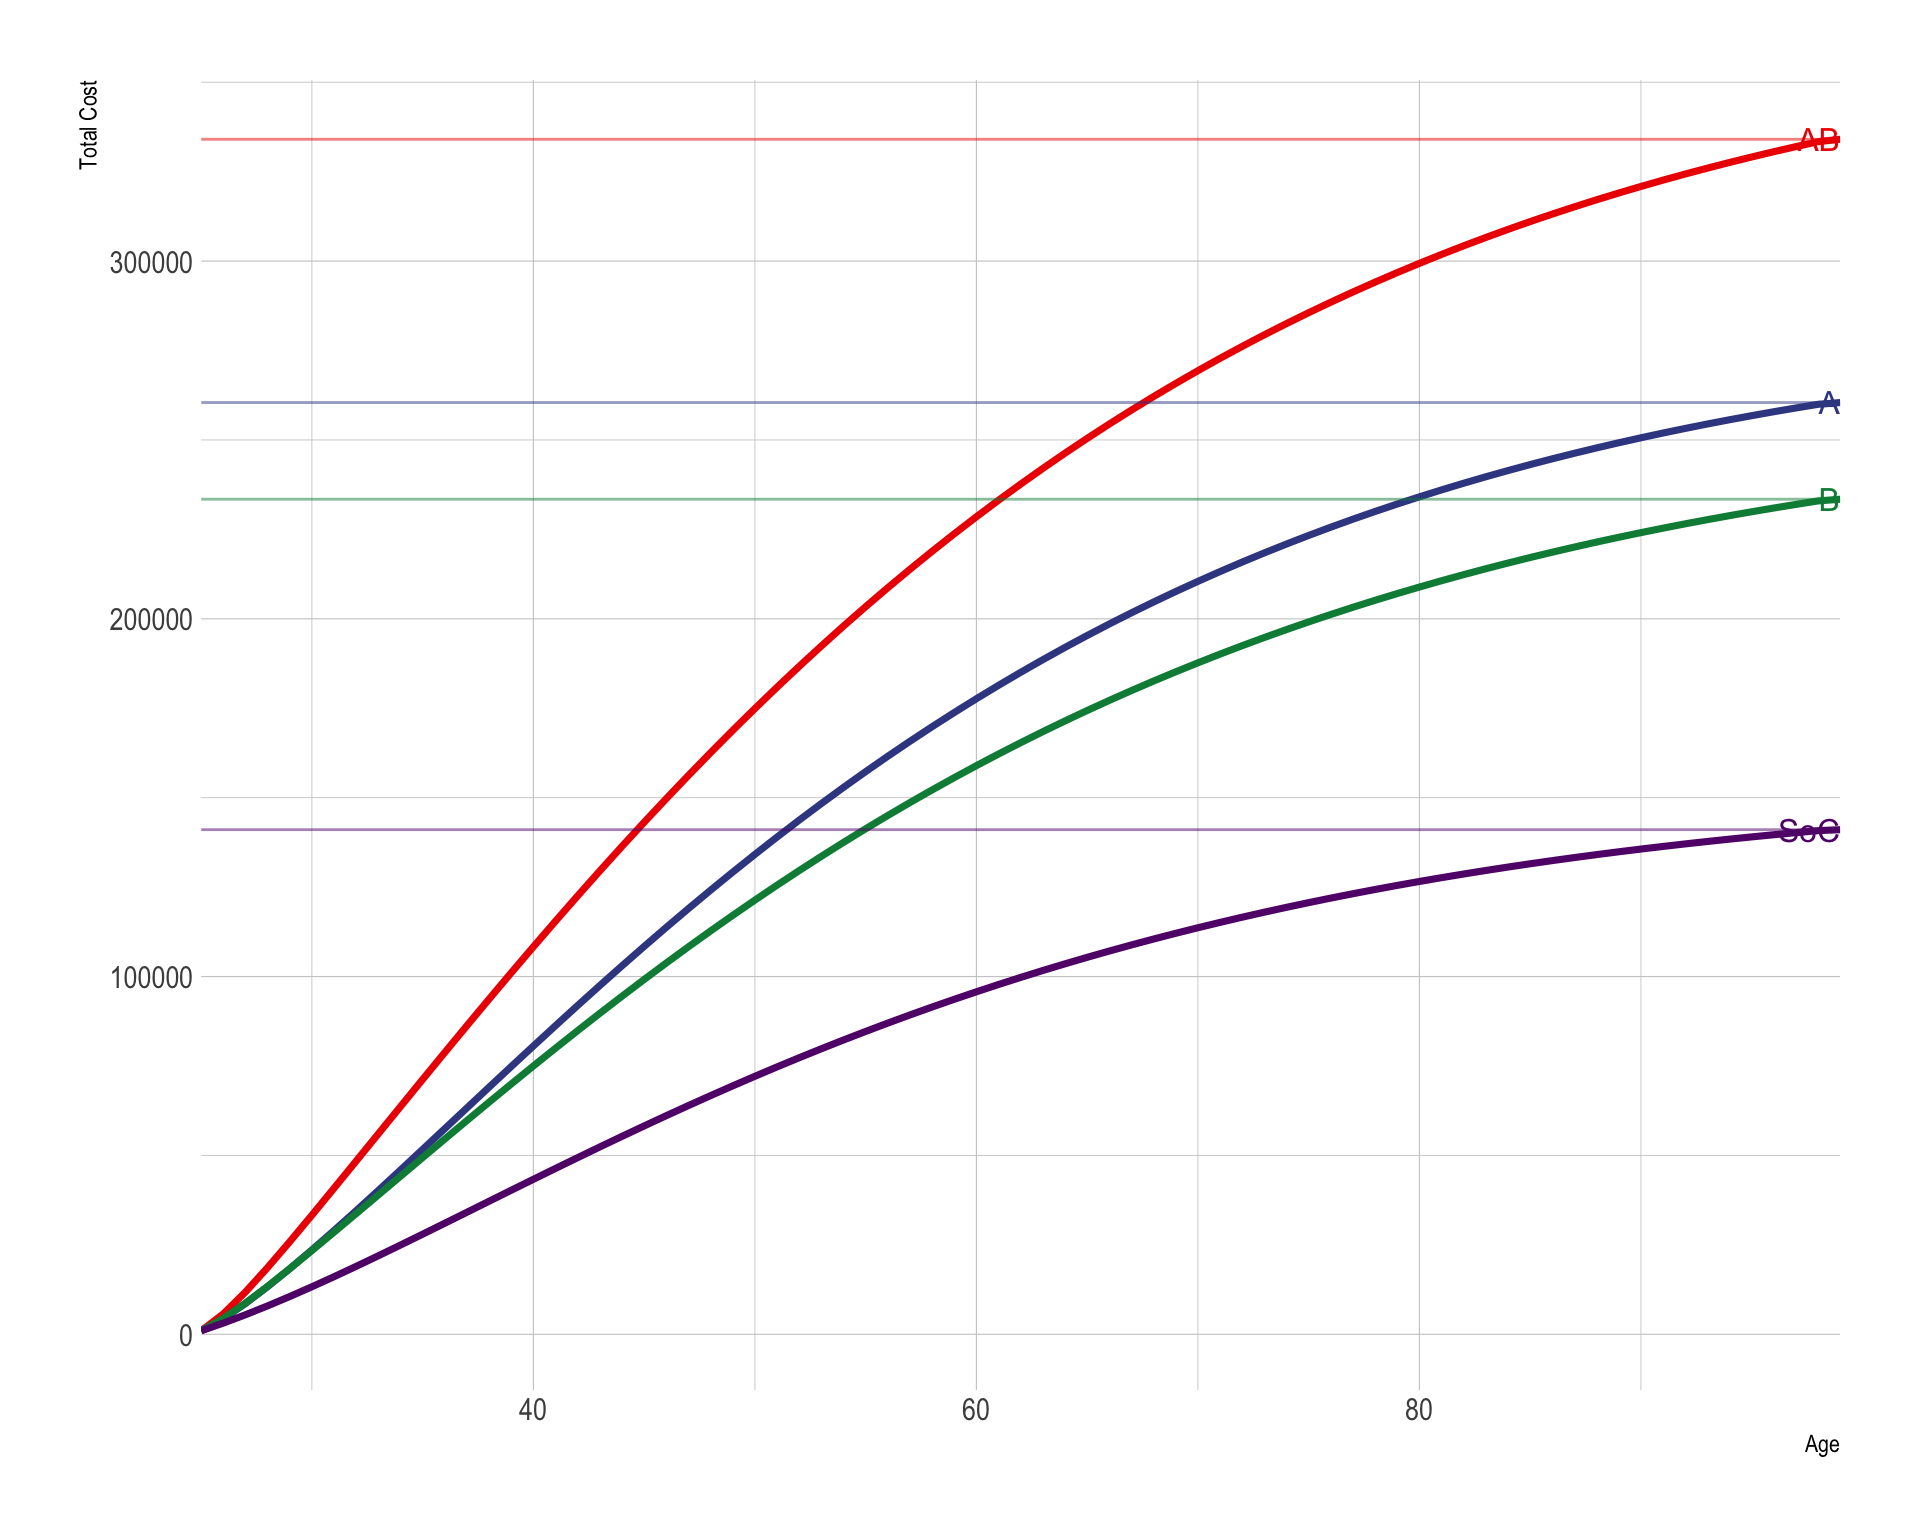

In [ ]:
p_decomp_cost

## 3.2 DALY Decomposition (Newborn Cohort)

In [ ]:
accumulating_YLD <-
  1:params_adv$omega %>% map( ~ ({
    # HYLD = H
    # HYLD[1,] = rep(0,ncol(H))

    H_ = with(params_adv, matrix(0, nrow = tau, ncol = omega))
    H_[, .x] <- c(0,1,1)
    V_YLD_ = V_YLD %>% map( ~ (.x * H_))
    res <-  params_adv %>% mcwr_occupancy(H = H_, V = V_YLD_)
    res %>% map( ~ ({
      as.data.frame(kronecker(diag(params_adv$omega), t(c(1, 0,0))) %*% as.matrix(.x)) %>%
        mutate(age = params_adv$ages)  %>%
        mutate(initial = params_adv$v_tr_names[1])
    })) %>%
      set_names(params_adv$v_tx_names) %>%
      bind_rows(.id = "strategy") %>%
      as_tibble() %>%
      filter(age == params_adv$age0) %>%
      mutate(age = params_adv$ages[.x])
  }))


mcwr_yll_byage <- function(params, life_expectancy, disc, aa_) {
  with(params,{
    map2(mUtilde,mPtilde,~({
      U = .x
      P = .y
      N = solve(diag(tau*omega)-U)
      Z = cbind(diag(tau*omega),matrix(0,nrow=tau*omega, ncol=alpha))
      disc_ = rev(sort(rep(disc,length(v_tr_names))))
      eta1_ex_ = rev(sort(rep(life_expectancy,length(v_tr_names))))
      # This gets age-by-age results
        eta1_ex = rep(0,length(eta1_ex_))
        eta1_ex[which(eta1_ex_==life_expectancy[aa_])] <- eta1_ex_[which(eta1_ex_==life_expectancy[aa_])]
        
      
      B1 = matrix(0,nrow=tau*omega, ncol = tau*omega)
      C1 = rbind(matrix(0,nrow=1,ncol=tau*omega),eta1_ex*disc_) 
      R1 = cbind(rbind(B1,C1),matrix(0,nrow=tau*omega+2,ncol=2))
      R2 = R1 * R1
      R3 = R1 * R1 * R1
      Z = cbind(diag(tau*omega),matrix(0,nrow=tau*omega, ncol=alpha))
      e = rep(1,s)
      rho1_ = t(N) %*% Z %*% t(.y * R1) %*% e
      rho1_
    }))
  })
}

accumulating_YLL <-
  1:params_adv$omega %>% map( ~ ({
    aa_ <- params_adv$ages[.x]
    res <- params_adv %>% mcwr_yll_byage(life_expectancy = remaining_life_expectancy, disc = v_discC_h[-1], aa_ = aa_)
    
    res %>% map( ~ ({
      as.data.frame(kronecker(diag(params_adv$omega), t(c(1, 0,0))) %*% as.matrix(.x)) %>%
        mutate(age = params_adv$ages)  %>%
        mutate(initial = params_adv$v_tr_names[1])
    })) %>%
      set_names(params_adv$v_tx_names) %>%
      bind_rows(.id = "strategy") %>%
      as_tibble() %>%
      filter(age == params_adv$age0) %>%
      mutate(age = params_adv$ages[.x])
  }))

accYLD <- 
  accumulating_YLD %>%
  bind_rows() %>%
  arrange(strategy,age) %>%
  group_by(strategy) %>%
  mutate(total = sum(V1))  %>%
  mutate(YLD = cumsum(V1)) %>%
  filter(age<=100) %>% 
  select(strategy,age,initial,total_YLD = total, YLD)

accYLL <- 
  accumulating_YLL %>%
  bind_rows() %>%
  arrange(strategy,age) %>%
  group_by(strategy) %>%
  mutate(total = sum(V1))  %>%
  mutate(YLL = cumsum(V1)) %>%
  filter(age<=100) %>% 
  select(strategy,age,initial,total_YLL = total, YLL)

total_DALY <- 
  accYLD %>% 
  inner_join(accYLL,c("strategy","age","initial")) %>% 
  select(strategy, total_YLD, total_YLL) %>% 
  unique() %>% 
  mutate(total_DALY = total_YLD + total_YLL)

p_decomp_daly <- 
  accYLD %>% 
  inner_join(accYLL,c("strategy","age","initial")) %>% 
  mutate(DALY = YLD + YLL) %>% 
  ggplot(aes(x = age, y = DALY, colour = strategy)) + geom_line(aes(colour = strategy),lwd=1.25) +
  theme_ipsum() +
  scale_colour_aaas() +
  scale_x_continuous(expand = c(0,0)) +
  geom_dl(method = list("last.points","bumpup", hjust=1),aes(label = strategy)) +
  theme(legend.position = "none") +  labs(x = "Age", y = "DALYs") + 
  geom_hline(data = total_DALY, aes(yintercept = total_DALY, colour = strategy),lty=1,alpha=0.5)

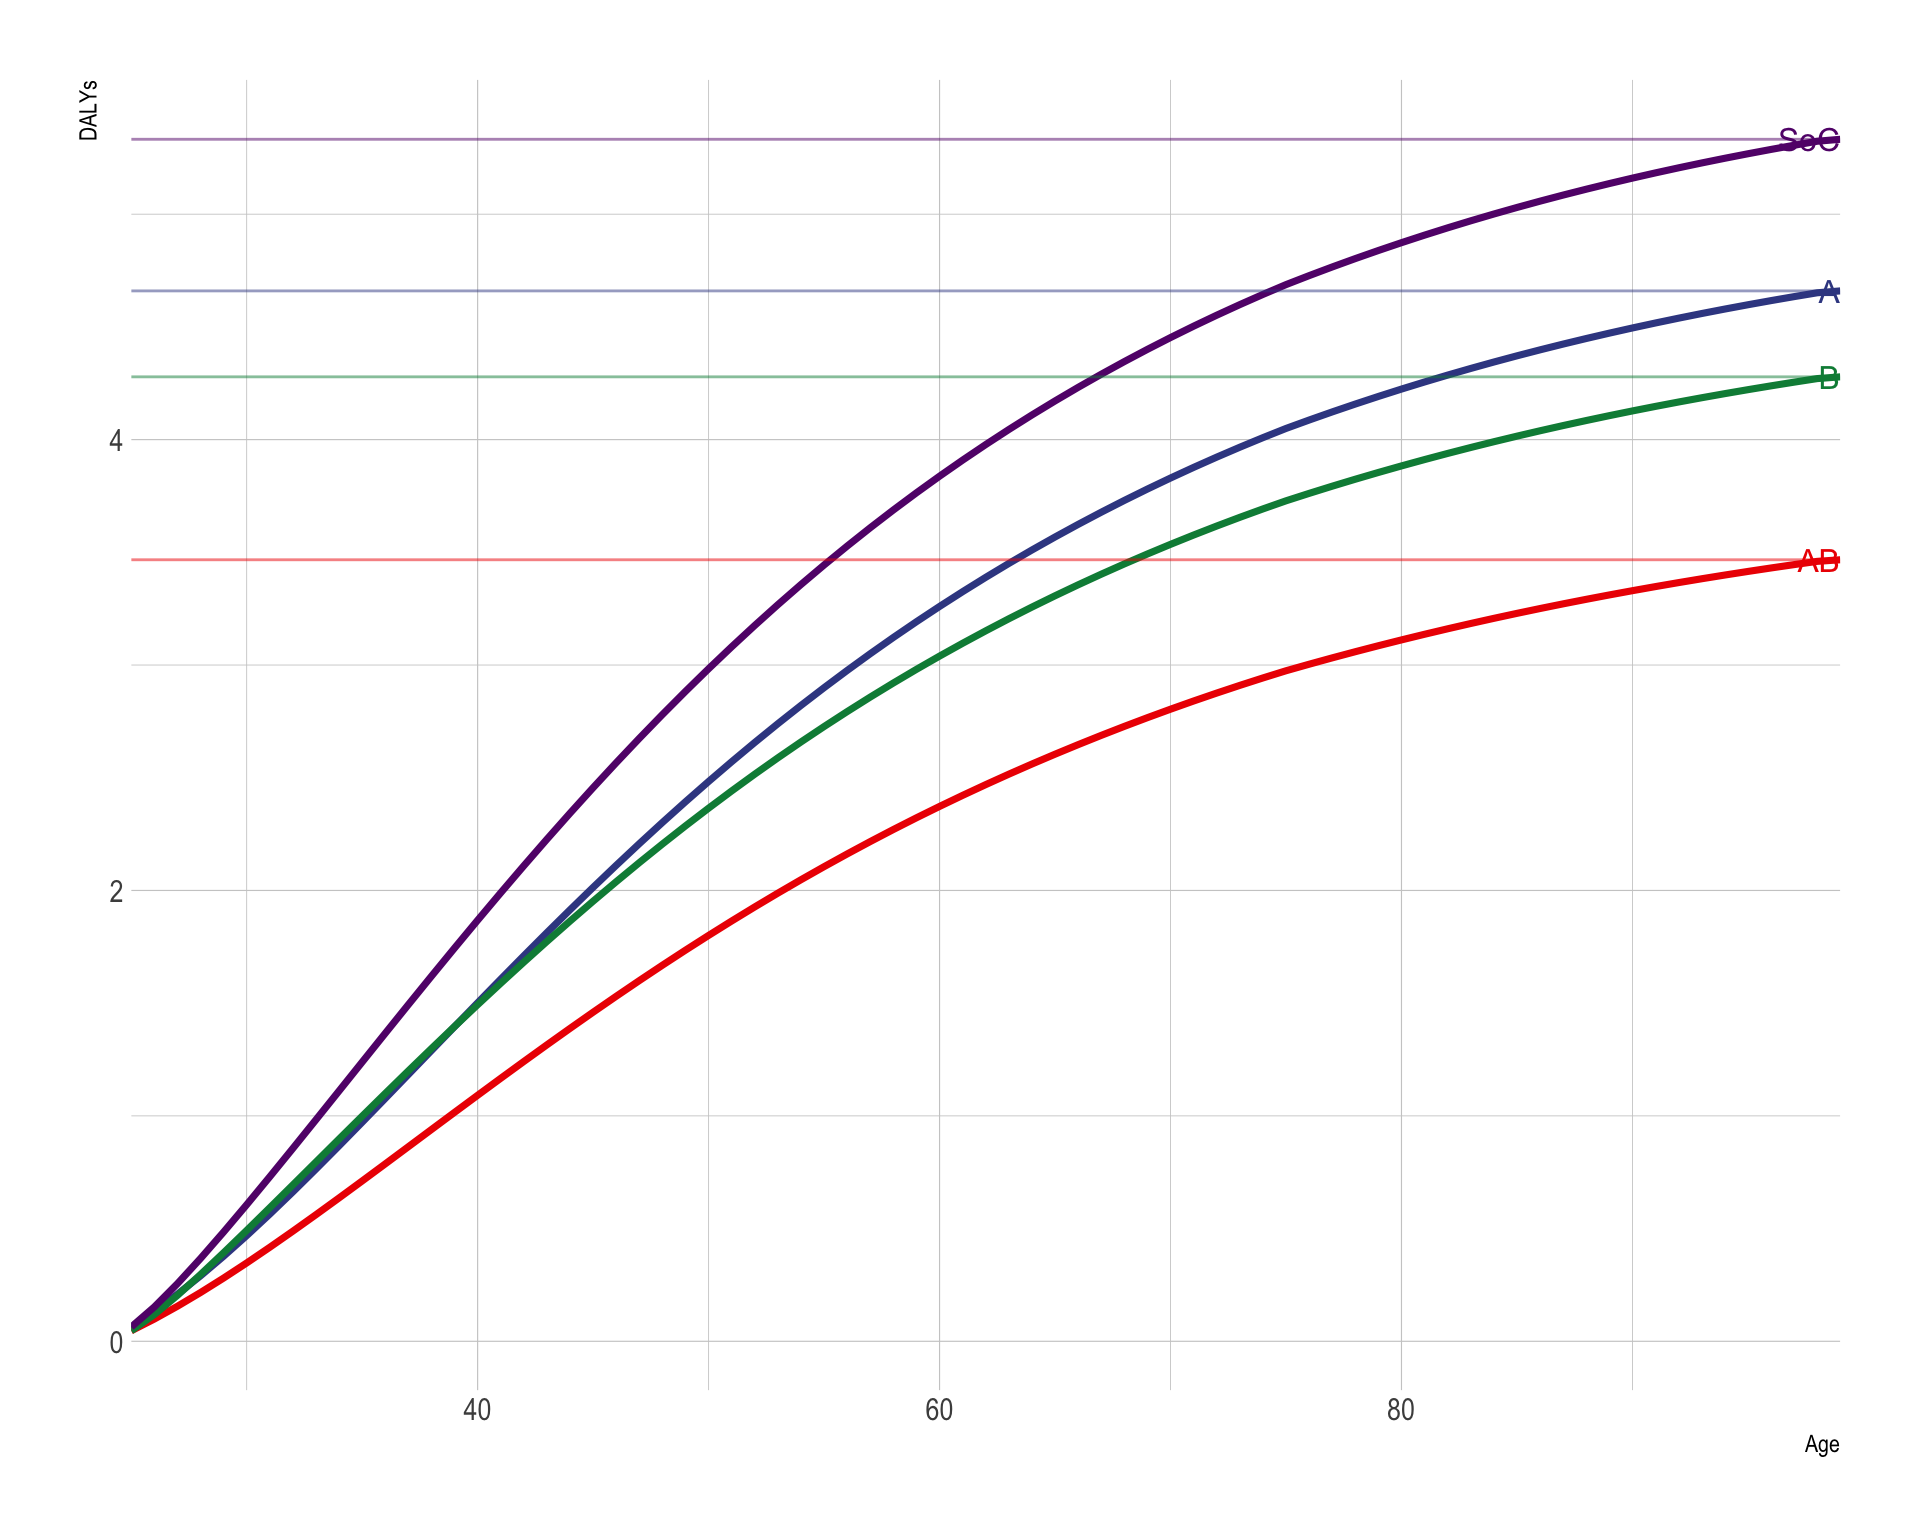

In [ ]:
p_decomp_daly

Alarid-Escudero, Fernando, Eline Krijkamp, Eva A Enns, Alan Yang, MG Myriam Hunink, Petros Pechlivanoglou, and Hawre Jalal. 2023. “An Introductory Tutorial on Cohort State-Transition Models in r Using a Cost-Effectiveness Analysis Example.” *Medical Decision Making* 43 (1): 3–20.

Caswell, Hal, and Silke van Daalen. 2021. “Healthy Longevity from Incidence-Based Models: More Kinds of Health Than Stars in the Sky.” *Demographic Research* 45 (July): 397–452. <https://doi.org/10.4054/demres.2021.45.13>.

Caswell, Hal, and Virginia Zarulli. 2018. “Matrix Methods in Health Demography: A New Approach to the Stochastic Analysis of Healthy Longevity and DALYs.” *Population Health Metrics* 16 (1). <https://doi.org/10.1186/s12963-018-0165-5>.

Graves, John, Shawn Garbett, Zilu Zhou, Jonathan S. Schildcrout, and Josh Peterson. 2021. “Comparison of Decision Modeling Approaches for Health Technology and Policy Evaluation.” *Medical Decision Making* 41 (4): 453–64. <https://doi.org/10.1177/0272989x21995805>.

Henderson, Harold V., and S. R. Searle. 1981. “The Vec-Permutation Matrix, the Vec Operator and Kronecker Products: A Review.” *Linear and Multilinear Algebra* 9 (4): 271–88. <https://doi.org/10.1080/03081088108817379>.

Iosifescu, M. 1980. “Finite Markov Processes and Their Applications. Wiley.” *New York*.